## Imports and Load GTFS data

In [ ]:
# Download the gtfs zip file and save it as "gtfs-nyc-2023.zip"
!wget -O "gtfs-nyc-2023.zip" https://transitfeeds.com/p/central-new-york-rta/524/latest/download

--2024-10-07 03:44:16--  https://transitfeeds.com/p/central-new-york-rta/524/latest/download
Resolving transitfeeds.com (transitfeeds.com)... 104.21.13.191, 172.67.133.18, 2606:4700:3034::ac43:8512, ...
Connecting to transitfeeds.com (transitfeeds.com)|104.21.13.191|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://openmobilitydata-data.s3-us-west-1.amazonaws.com/public/feeds/central-new-york-rta/524/20231215/gtfs.zip [following]
--2024-10-07 03:44:16--  https://openmobilitydata-data.s3-us-west-1.amazonaws.com/public/feeds/central-new-york-rta/524/20231215/gtfs.zip
Resolving openmobilitydata-data.s3-us-west-1.amazonaws.com (openmobilitydata-data.s3-us-west-1.amazonaws.com)... 52.219.112.153, 52.219.216.66, 3.5.160.162, ...
Connecting to openmobilitydata-data.s3-us-west-1.amazonaws.com (openmobilitydata-data.s3-us-west-1.amazonaws.com)|52.219.112.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3399914 (3.2M) [application

In [ ]:
!pip install folium shapely geopandas gtfs-kit

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.2/543.2 kB 30.3 MB/s eta 0:00:00
  Created wheel for json2html: filename=json2html-1.3.0-py3-none-any.whl size=7591 sha256=6a4d779a685de7039bf3ea699a46450078f213394278f7b541cad64d6ad99309
  Stored in directory: /root/.cache/pip/wheels/e0/d8/b3/6f83a04ab0ec00e691de794d108286bb0f8bcdf4ade19afb57
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6085 sha256=0d1b7525c0c03e42f69d962177051ab6cbcfd41512c1c4b3a9eea36da195f828
  Stored in directory: /root/.cache/pip/wheels/2f/a1/c8/543df0e8f5e824c3e92a432e32deb9cd89ae686095ee8cfcbe
Successfully built json2html utm


In [ ]:
!pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.8 MB/s eta 0:00:00


In [ ]:
import os
from os import path
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import folium
from shapely.geometry import LineString, Point
from folium.plugins import MarkerCluster, HeatMap
from folium import Marker, Icon, Circle, CircleMarker, GeoJson, PolyLine, Map
from geopy.distance import geodesic

In [ ]:
import json

In [ ]:
import gtfs_kit as gk

In [ ]:
path = Path('/content/gtfs-nyc-2023.zip')

In [ ]:
feed = gk.read_feed(path, dist_units='km')

In [ ]:
gtfs_validation = feed.validate()
gtfs_validation

,type,message,table,rows
2,error,Invalid arrival_time; maybe has extra space ch...,stop_times,"[106816, 106817, 106818, 106819, 106820, 10682..."
3,error,Invalid departure_time; maybe has extra space ...,stop_times,"[106816, 106817, 106818, 106819, 106820, 10682..."
0,warning,Feed expired,calendar/calendar_dates,[]
1,warning,Route has no trips,routes,"[28, 36, 63, 68]"
4,warning,"Repeated pair (trip_id, departure_time)",stop_times,"[108932, 108957, 108982, 109007, 109032, 10905..."


In [ ]:
gtfs_validation['num_rows'] = gtfs_validation['rows'].apply(lambda x: len(x))
gtfs_validation

,type,message,table,rows,num_rows
2,error,Invalid arrival_time; maybe has extra space ch...,stop_times,"[106816, 106817, 106818, 106819, 106820, 10682...",57135
3,error,Invalid departure_time; maybe has extra space ...,stop_times,"[106816, 106817, 106818, 106819, 106820, 10682...",57134
0,warning,Feed expired,calendar/calendar_dates,[],0
1,warning,Route has no trips,routes,"[28, 36, 63, 68]",4
4,warning,"Repeated pair (trip_id, departure_time)",stop_times,"[108932, 108957, 108982, 109007, 109032, 10905...",35


In [ ]:
stop_times = feed.stop_times.copy()
stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint
0,1619710,16:30:00,16:30:00,12493,1,NaN,0,0,NaN,1
1,1619710,16:31:40,16:31:40,12052,2,NaN,0,0,0.4553,0
2,1619710,16:32:35,16:32:35,12053,3,NaN,0,0,0.7063,0
3,1619710,16:33:18,16:33:18,18002,4,NaN,0,0,0.9035,0
4,1619710,16:33:46,16:33:46,12055,5,NaN,0,0,1.0303,0


In [ ]:
stop_times.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229928 entries, 0 to 229927
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   trip_id              229928 non-null  object 
 1   arrival_time         229928 non-null  object 
 2   departure_time       229928 non-null  object 
 3   stop_id              229928 non-null  object 
 4   stop_sequence        229928 non-null  int64  
 5   stop_headsign        0 non-null       object 
 6   pickup_type          229928 non-null  int64  
 7   drop_off_type        229928 non-null  int64  
 8   shape_dist_traveled  221935 non-null  float64
 9   timepoint            229928 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 17.5+ MB


In [ ]:
stop_times.isnull().sum()

,0
trip_id,0
arrival_time,0
departure_time,0
stop_id,0
stop_sequence,0
stop_headsign,229928
pickup_type,0
drop_off_type,0
shape_dist_traveled,7993
timepoint,0


In [ ]:
# Checking Arrival Time and Departure Time
num_of_invalid_AT = stop_times['arrival_time'].str.contains(' ').sum()
print(f"Percentage of Data of Arrival Time containing Spaces: {(num_of_invalid_AT / len(stop_times) * 100):.2f}%")

num_of_invalid_DT = stop_times['departure_time'].str.contains(' ').sum()
print(f"Percentage of Data of Departure Time containing Spaces: {(num_of_invalid_DT / len(stop_times) * 100):.2f}%")

Percentage of Data of Arrival Time containing Spaces: 24.85%
Percentage of Data of Departure Time containing Spaces: 24.85%


In [ ]:
# Removing the space from the Arrival and Departure Time
stop_times['arrival_time'] = stop_times['arrival_time'].str.replace(' ', '')
stop_times['departure_time'] = stop_times['departure_time'].str.replace(' ', '')

In [ ]:
# Checking Arrival and Departure TIme Containing Null Values
arrival_time_missing_values = stop_times['arrival_time'].apply(lambda x: np.nan if x == '' else x).isnull().sum()
print(f"Percentage of Data of Arrival Time containing Null Values: {(arrival_time_missing_values / len(stop_times) * 100).round(2)}%")

departure_time_missing_values = stop_times['departure_time'].apply(lambda x: np.nan if x == '' else x).isnull().sum()
print(f"Percentage of Data of Departure Time containing Null Values: {(departure_time_missing_values / len(stop_times) * 100).round(2)}%")

Percentage of Data of Arrival Time containing Null Values: 0.0%
Percentage of Data of Departure Time containing Null Values: 0.0%


In [ ]:
stop_times.duplicated().sum()

0

In [ ]:
feed.stop_times = stop_times

In [ ]:
feed.routes.head()

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,19627,Centro,Aub 1,West Genesee,NaN,3,NaN,38A848,FFFFFF
1,19628,Centro,Aub 2,Franklin,NaN,3,NaN,3C62AE,FFFFFF
2,19629,Centro,Aub 3,North Street,NaN,3,NaN,7E3092,FFFFFF
3,19630,Centro,Aub 4,State Street,NaN,3,NaN,D98C27,FFFFFF
4,19631,Centro,Aub 6,Wegmans Shoppers,NaN,3,NaN,00FF00,FFFFFF


In [ ]:
routes_with_no_trips = []
for idx, row in feed.routes.iterrows():
    if len(feed.trips[feed.trips['route_id'] == row['route_id']]) == 0:
        routes_with_no_trips.append(row['route_id'])
        print(idx)

28
36
63
68


In [ ]:
routes_with_no_trips

['19685', '19693', '19720', '19725']

In [ ]:
# Removing all the routes with no trips i.e. routes_with_no_trips
feed.routes = feed.routes[~feed.routes['route_id'].isin(routes_with_no_trips)]

In [ ]:
feed.validate()

,type,message,table,rows
0,warning,Feed expired,calendar/calendar_dates,[]
1,warning,"Repeated pair (trip_id, departure_time)",stop_times,"[108932, 108957, 108982, 109007, 109032, 10905..."


In [ ]:
feed.trips.head()

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed
0,19627,1,1619723,1 West Genesee - Mercy Rehab.,NaN,0,255320,138172,0,0
1,19627,1,1619722,1 West Genesee - Tops Market,NaN,0,255321,138170,0,0
2,19627,1,1619721,1 West Genesee - Fingerlakes Mall,NaN,0,255318,138171,0,0
3,19627,1,1619720,1 West Genesee - Fingerlakes Mall,NaN,0,255319,138169,0,0
4,19627,1,1619719,1 West Genesee - Fingerlakes Mall,NaN,0,255318,138171,0,0


In [ ]:
feed.stops.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding
0,17,17,Thurber St & Alden St,NaN,43.018504,-76.133335,NaN,NaN,NaN,NaN,NaN,0
1,22,22,Thompson Rd & Springfield Rd,SPRINGFIELD RD,43.051660,-76.080436,NaN,NaN,NaN,NaN,NaN,0
2,28,28,Bishop Grimes,NaN,43.077158,-76.060720,NaN,NaN,NaN,NaN,NaN,0
3,47,47,Regional Transportation Center,NaN,43.076641,-76.169373,NaN,NaN,NaN,NaN,NaN,0
4,50,50,Loretto Rest,NaN,43.004997,-76.135725,NaN,NaN,NaN,NaN,NaN,0


In [ ]:
feed.calendar_dates.head()

,service_id,date,exception_type
0,177404,20230904,1
1,177204,20230904,1
2,4,20230904,1
3,1,20230904,2
4,51501,20230905,1


In [ ]:
gk.list_feed(path)

,file_name,file_size
0,agency.txt,183
1,calendar.txt,2175
2,calendar_dates.txt,37933
3,feed_info.txt,168
4,google.log,215438
5,routes.txt,5090
6,shapes.txt,6149794
7,stop_times.txt,11260379
8,stops.txt,383868
9,transfers.txt,25206


In [ ]:
# Columns of Routes, Shapes, Stop Times, Stops, Trips
print(feed.routes.columns)
print(feed.shapes.columns)
print(feed.stop_times.columns)
print(feed.stops.columns)
print(feed.trips.columns)

Index(['route_id', 'agency_id', 'route_short_name', 'route_long_name',
       'route_desc', 'route_type', 'route_url', 'route_color',
       'route_text_color'],
      dtype='object')
Index(['shape_id', 'shape_pt_lat', 'shape_pt_lon', 'shape_pt_sequence',
       'shape_dist_traveled'],
      dtype='object')
Index(['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'stop_sequence',
       'stop_headsign', 'pickup_type', 'drop_off_type', 'shape_dist_traveled',
       'timepoint'],
      dtype='object')
Index(['stop_id', 'stop_code', 'stop_name', 'stop_desc', 'stop_lat',
       'stop_lon', 'zone_id', 'stop_url', 'location_type', 'parent_station',
       'stop_timezone', 'wheelchair_boarding'],
      dtype='object')
Index(['route_id', 'service_id', 'trip_id', 'trip_headsign', 'trip_short_name',
       'direction_id', 'block_id', 'shape_id', 'wheelchair_accessible',
       'bikes_allowed'],
      dtype='object')


In [ ]:
routes = feed.routes.copy()
shapes = feed.shapes.copy()
stop_times = feed.stop_times.copy()
stops = feed.stops.copy()
trips = feed.trips.copy()

In [ ]:
# Printing shape of all the data
print(f"Shape of Routes: {routes.shape}")
print(f"Shape of Shapes: {shapes.shape}")
print(f"Shape of Stop Times: {stop_times.shape}")
print(f"Shape of Stops: {stops.shape}")
print(f"Shape of Trips: {trips.shape}")

Shape of Routes: (89, 9)
Shape of Shapes: (154088, 5)
Shape of Stop Times: (229928, 10)
Shape of Stops: (5724, 12)
Shape of Trips: (7993, 10)


In [ ]:
calendard_dates = feed.calendar_dates.copy()

## EDA

### Data Cleaning

#### **1. `routes` Data**

In [ ]:
# Data Cleaning for Routes
routes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89 entries, 0 to 92
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   route_id          89 non-null     object
 1   agency_id         89 non-null     object
 2   route_short_name  89 non-null     object
 3   route_long_name   89 non-null     object
 4   route_desc        0 non-null      object
 5   route_type        89 non-null     int64 
 6   route_url         0 non-null      object
 7   route_color       89 non-null     object
 8   route_text_color  89 non-null     object
dtypes: int64(1), object(8)
memory usage: 7.0+ KB


In [ ]:
routes.head()

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,19627,Centro,Aub 1,West Genesee,NaN,3,NaN,38A848,FFFFFF
1,19628,Centro,Aub 2,Franklin,NaN,3,NaN,3C62AE,FFFFFF
2,19629,Centro,Aub 3,North Street,NaN,3,NaN,7E3092,FFFFFF
3,19630,Centro,Aub 4,State Street,NaN,3,NaN,D98C27,FFFFFF
4,19631,Centro,Aub 6,Wegmans Shoppers,NaN,3,NaN,00FF00,FFFFFF


In [ ]:
unique_routes = routes.route_id.nunique()
unique_routes

89

In [ ]:
routes.route_text_color.value_counts()

,count
route_text_color,
FFFFFF,72
000000,17


In [ ]:
routes_imp_features = ['route_id', 'route_long_name', 'route_type', 'route_color', 'route_text_color']
routes = routes[routes_imp_features]

#### **2. `shapes` Data**

In [ ]:
shapes.head()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,138169,42.932684,-76.566934,1,0.0000
1,138169,42.932532,-76.567233,2,0.0294
2,138169,42.931896,-76.568493,3,0.1539
3,138169,42.931846,-76.568571,4,0.1624
4,138169,42.931736,-76.568708,5,0.1787


In [ ]:
shapes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154088 entries, 0 to 154087
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   shape_id             154088 non-null  object 
 1   shape_pt_lat         154088 non-null  float64
 2   shape_pt_lon         154088 non-null  float64
 3   shape_pt_sequence    154088 non-null  int64  
 4   shape_dist_traveled  154088 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 5.9+ MB


In [ ]:
unique_shapes = shapes.shape_id.nunique()
print(f"Total number of shapes: {unique_shapes}")

Total number of shapes: 641


In [ ]:
# Sort the Shapes by shape_id followed by shape_pt_sequence
shapes = shapes.sort_values(by=['shape_id', 'shape_pt_sequence'])

#### **3. `stops` Data**

In [ ]:
stops.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding
0,17,17,Thurber St & Alden St,NaN,43.018504,-76.133335,NaN,NaN,NaN,NaN,NaN,0
1,22,22,Thompson Rd & Springfield Rd,SPRINGFIELD RD,43.051660,-76.080436,NaN,NaN,NaN,NaN,NaN,0
2,28,28,Bishop Grimes,NaN,43.077158,-76.060720,NaN,NaN,NaN,NaN,NaN,0
3,47,47,Regional Transportation Center,NaN,43.076641,-76.169373,NaN,NaN,NaN,NaN,NaN,0
4,50,50,Loretto Rest,NaN,43.004997,-76.135725,NaN,NaN,NaN,NaN,NaN,0


In [ ]:
unique_stops = stops.stop_id.nunique()
print(f"Total number of stops: {unique_stops}")

Total number of stops: 5724


In [ ]:
stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5724 entries, 0 to 5723
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   stop_id              5724 non-null   object 
 1   stop_code            5724 non-null   object 
 2   stop_name            5724 non-null   object 
 3   stop_desc            386 non-null    object 
 4   stop_lat             5724 non-null   float64
 5   stop_lon             5724 non-null   float64
 6   zone_id              0 non-null      object 
 7   stop_url             0 non-null      object 
 8   location_type        0 non-null      float64
 9   parent_station       0 non-null      object 
 10  stop_timezone        0 non-null      object 
 11  wheelchair_boarding  5724 non-null   int64  
dtypes: float64(3), int64(1), object(8)
memory usage: 536.8+ KB


In [ ]:
stops.wheelchair_boarding.value_counts()

,count
wheelchair_boarding,
0,5724


In [ ]:
stops = stops[['stop_id', 'stop_code', 'stop_name', 'stop_lat', 'stop_lon']]

#### **4. `trips` Data**

In [ ]:
trips.head()

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed
0,19627,1,1619723,1 West Genesee - Mercy Rehab.,NaN,0,255320,138172,0,0
1,19627,1,1619722,1 West Genesee - Tops Market,NaN,0,255321,138170,0,0
2,19627,1,1619721,1 West Genesee - Fingerlakes Mall,NaN,0,255318,138171,0,0
3,19627,1,1619720,1 West Genesee - Fingerlakes Mall,NaN,0,255319,138169,0,0
4,19627,1,1619719,1 West Genesee - Fingerlakes Mall,NaN,0,255318,138171,0,0


In [ ]:
unique_trips = trips.trip_id.nunique()
print(f"Total number of trips: {unique_trips}")

Total number of trips: 7993


In [ ]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7993 entries, 0 to 7992
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   route_id               7993 non-null   object
 1   service_id             7993 non-null   object
 2   trip_id                7993 non-null   object
 3   trip_headsign          7993 non-null   object
 4   trip_short_name        0 non-null      object
 5   direction_id           7993 non-null   int64 
 6   block_id               7993 non-null   object
 7   shape_id               7993 non-null   object
 8   wheelchair_accessible  7993 non-null   int64 
 9   bikes_allowed          7993 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 624.6+ KB


In [ ]:
trips.groupby(by=['route_id']).agg(
    NumTrips=('trip_headsign', 'nunique'),
    NumShapes=('shape_id', 'nunique')
)

,NumTrips,NumShapes
route_id,,
19627,4,9
19628,3,4
19629,2,5
19630,3,11
19631,1,3
...,...,...
19749,2,3
19750,6,9
19751,2,6


In [ ]:
trips.trip_headsign.value_counts()

,count
trip_headsign,
582 Orange Lot,885
344 South Campus,435
344 South Campus - Skytop,431
909 Destiny USA PNR,285
782 Willis Ave,210
...,...
7252 Townsend St - Court St,1
7264 Townsend - W Onondaga,1
2176 Teall Ave - Salt Springs Rd,1


In [ ]:
total_services = trips.service_id.nunique()
print(f"Total number of services: {total_services}")

total_blocks = trips.block_id.nunique()
print(f"Total number of blocks: {total_blocks}")

total_routes = trips.route_id.nunique()
print(f"Total number of routes: {total_routes}")

total_shapes = trips.shape_id.nunique()
print(f"Total number of shapes: {total_shapes}")

Total number of services: 54
Total number of blocks: 742
Total number of routes: 89
Total number of shapes: 641


In [ ]:
trips.direction_id.value_counts()

,count
direction_id,
0,4743
1,3250


In [ ]:
trips.wheelchair_accessible.nunique()

1

In [ ]:
trips.bikes_allowed.nunique()

1

#### **5. `calendar_dates` Data**

In [ ]:
calendard_dates.head()

,service_id,date,exception_type
0,177404,20230904,1
1,177204,20230904,1
2,4,20230904,1
3,1,20230904,2
4,51501,20230905,1


In [ ]:
calendard_dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101 entries, 0 to 2100
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   service_id      2101 non-null   object
 1   date            2101 non-null   object
 2   exception_type  2101 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 49.4+ KB


In [ ]:
unique_services = calendard_dates.service_id.nunique()
print(f"Total number of services: {unique_services}")

Total number of services: 41


In [ ]:
calendard_dates.groupby(by=['service_id']).agg(
    TotalDates=('date', 'count'),
    MinDate=('date', 'min'),
    MaxDate=('date', 'max')
).sort_values(by='TotalDates', ascending=False).reset_index()

,service_id,TotalDates,MinDate,MaxDate
0,115101,109,20230906,20240301
1,53101,109,20230906,20240301
2,3601,109,20230906,20240301
3,125101,109,20230906,20240301
4,3701,109,20230906,20240301
5,179101,109,20230906,20240301
6,53501,109,20230906,20240301
7,177501,109,20230906,20240301
8,3101,105,20230905,20240301
9,52901,104,20230907,20240301


#### **6. `stop_times` Data**

In [ ]:
stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint
0,1619710,16:30:00,16:30:00,12493,1,NaN,0,0,NaN,1
1,1619710,16:31:40,16:31:40,12052,2,NaN,0,0,0.4553,0
2,1619710,16:32:35,16:32:35,12053,3,NaN,0,0,0.7063,0
3,1619710,16:33:18,16:33:18,18002,4,NaN,0,0,0.9035,0
4,1619710,16:33:46,16:33:46,12055,5,NaN,0,0,1.0303,0


In [ ]:
stop_times.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229928 entries, 0 to 229927
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   trip_id              229928 non-null  object 
 1   arrival_time         229928 non-null  object 
 2   departure_time       229928 non-null  object 
 3   stop_id              229928 non-null  object 
 4   stop_sequence        229928 non-null  int64  
 5   stop_headsign        0 non-null       object 
 6   pickup_type          229928 non-null  int64  
 7   drop_off_type        229928 non-null  int64  
 8   shape_dist_traveled  221935 non-null  float64
 9   timepoint            229928 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 17.5+ MB


In [ ]:
# Checking Time between 0-23 for arrival and departure time
stop_times_with_24hr_at = stop_times[stop_times['arrival_time'].str.startswith('24')]
stop_times_with_24hr_dt = stop_times[stop_times['departure_time'].str.startswith('24')]

print(f"Number of data point with 24 hour arrival time: {len(stop_times_with_24hr_at)}")
print(f"Number of data point with 24 hour departure time: {len(stop_times_with_24hr_dt)}")

Number of data point with 24 hour arrival time: 2486
Number of data point with 24 hour departure time: 2489


In [ ]:
# Clean the 24hr and add today's date to it
# For Time having 24 hour add increment the current date
# For Instance, "16:35:24" to "2024-09-27 16:35:24" and "24:12:23" to "2024-09-28 00:12:23"
def clean_time(x):
    date = datetime.datetime.today()
    hr, min, sec = x.split(':')
    if x.startswith('24'):
        date = date + datetime.timedelta(days=1)
        hr = '00'
    x = f"{date.strftime('%Y-%m-%d')} {hr}:{min}:{sec}"
    return x


In [ ]:
# Clean the stop_times arrival and departure time
stop_times['arrival_time'] = stop_times['arrival_time'].apply(clean_time)
stop_times['departure_time'] = stop_times['departure_time'].apply(clean_time)

In [ ]:
stop_times_with_24hr_at = stop_times[stop_times['arrival_time'].str.startswith('24')]
stop_times_with_24hr_dt = stop_times[stop_times['departure_time'].str.startswith('24')]

print(f"Number of data point with 24 hour arrival time: {len(stop_times_with_24hr_at)}")
print(f"Number of data point with 24 hour departure time: {len(stop_times_with_24hr_dt)}")

Number of data point with 24 hour arrival time: 0
Number of data point with 24 hour departure time: 0


In [ ]:
stop_times['arrival_time'] = pd.to_datetime(stop_times['arrival_time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
stop_times['departure_time'] = pd.to_datetime(stop_times['departure_time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [ ]:
# Clean Stop Times Shape Distance Traveled
stop_times['shape_dist_traveled'] = stop_times['shape_dist_traveled'].fillna(0)

In [ ]:
stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint
0,1619710,2024-10-07 16:30:00,2024-10-07 16:30:00,12493,1,NaN,0,0,0.0000,1
1,1619710,2024-10-07 16:31:40,2024-10-07 16:31:40,12052,2,NaN,0,0,0.4553,0
2,1619710,2024-10-07 16:32:35,2024-10-07 16:32:35,12053,3,NaN,0,0,0.7063,0
3,1619710,2024-10-07 16:33:18,2024-10-07 16:33:18,18002,4,NaN,0,0,0.9035,0
4,1619710,2024-10-07 16:33:46,2024-10-07 16:33:46,12055,5,NaN,0,0,1.0303,0


In [ ]:
total_trips = stop_times.trip_id.nunique()
print(f"Total number of trips: {total_trips}")

Total number of trips: 7993


In [ ]:
total_stops = stop_times.stop_id.nunique()
print(f"Total number of stops: {total_stops}")

Total number of stops: 5724


### Data Joins for Analysis

In [ ]:
# Associate Trips with Routes
trips_routes = trips.merge(routes, on='route_id', how='inner')
trips_routes.head()

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed,route_long_name,route_type,route_color,route_text_color
0,19627,1,1619723,1 West Genesee - Mercy Rehab.,NaN,0,255320,138172,0,0,West Genesee,3,38A848,FFFFFF
1,19627,1,1619722,1 West Genesee - Tops Market,NaN,0,255321,138170,0,0,West Genesee,3,38A848,FFFFFF
2,19627,1,1619721,1 West Genesee - Fingerlakes Mall,NaN,0,255318,138171,0,0,West Genesee,3,38A848,FFFFFF
3,19627,1,1619720,1 West Genesee - Fingerlakes Mall,NaN,0,255319,138169,0,0,West Genesee,3,38A848,FFFFFF
4,19627,1,1619719,1 West Genesee - Fingerlakes Mall,NaN,0,255318,138171,0,0,West Genesee,3,38A848,FFFFFF


In [ ]:
trips_routes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7993 entries, 0 to 7992
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   route_id               7993 non-null   object
 1   service_id             7993 non-null   object
 2   trip_id                7993 non-null   object
 3   trip_headsign          7993 non-null   object
 4   trip_short_name        0 non-null      object
 5   direction_id           7993 non-null   int64 
 6   block_id               7993 non-null   object
 7   shape_id               7993 non-null   object
 8   wheelchair_accessible  7993 non-null   int64 
 9   bikes_allowed          7993 non-null   int64 
 10  route_long_name        7993 non-null   object
 11  route_type             7993 non-null   int64 
 12  route_color            7993 non-null   object
 13  route_text_color       7993 non-null   object
dtypes: int64(4), object(10)
memory usage: 874.4+ KB


In [ ]:
# To link stop_times with trips_routes
stop_times_trips = stop_times.merge(trips_routes, on='trip_id', how='inner')
stop_times_trips.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,...,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed,route_long_name,route_type,route_color,route_text_color
0,1619710,2024-10-07 16:30:00,2024-10-07 16:30:00,12493,1,NaN,0,0,0.0000,1,...,NaN,0,255319,138171,0,0,West Genesee,3,38A848,FFFFFF
1,1619710,2024-10-07 16:31:40,2024-10-07 16:31:40,12052,2,NaN,0,0,0.4553,0,...,NaN,0,255319,138171,0,0,West Genesee,3,38A848,FFFFFF
2,1619710,2024-10-07 16:32:35,2024-10-07 16:32:35,12053,3,NaN,0,0,0.7063,0,...,NaN,0,255319,138171,0,0,West Genesee,3,38A848,FFFFFF
3,1619710,2024-10-07 16:33:18,2024-10-07 16:33:18,18002,4,NaN,0,0,0.9035,0,...,NaN,0,255319,138171,0,0,West Genesee,3,38A848,FFFFFF
4,1619710,2024-10-07 16:33:46,2024-10-07 16:33:46,12055,5,NaN,0,0,1.0303,0,...,NaN,0,255319,138171,0,0,West Genesee,3,38A848,FFFFFF


In [ ]:
stop_times_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229928 entries, 0 to 229927
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trip_id                229928 non-null  object        
 1   arrival_time           229928 non-null  datetime64[ns]
 2   departure_time         229928 non-null  datetime64[ns]
 3   stop_id                229928 non-null  object        
 4   stop_sequence          229928 non-null  int64         
 5   stop_headsign          0 non-null       object        
 6   pickup_type            229928 non-null  int64         
 7   drop_off_type          229928 non-null  int64         
 8   shape_dist_traveled    229928 non-null  float64       
 9   timepoint              229928 non-null  int64         
 10  route_id               229928 non-null  object        
 11  service_id             229928 non-null  object        
 12  trip_headsign          229928 non-null  obje

In [ ]:
# To like stop_times with stops
stop_times_trips_stops = stop_times_trips.merge(stops, on='stop_id', how='inner')
stop_times_trips_stops.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,...,wheelchair_accessible,bikes_allowed,route_long_name,route_type,route_color,route_text_color,stop_code,stop_name,stop_lat,stop_lon
0,1619710,2024-10-07 16:30:00,2024-10-07 16:30:00,12493,1,NaN,0,0,0.0000,1,...,0,0,West Genesee,3,38A848,FFFFFF,12493,Dill St & North St,42.932595,-76.566967
1,1619710,2024-10-07 16:31:40,2024-10-07 16:31:40,12052,2,NaN,0,0,0.4553,0,...,0,0,West Genesee,3,38A848,FFFFFF,12052,Genesee St & Green Street,42.930415,-76.568965
2,1619710,2024-10-07 16:32:35,2024-10-07 16:32:35,12053,3,NaN,0,0,0.7063,0,...,0,0,West Genesee,3,38A848,FFFFFF,12053,Genesee St & James St,42.929138,-76.571509
3,1619710,2024-10-07 16:33:18,2024-10-07 16:33:18,18002,4,NaN,0,0,0.9035,0,...,0,0,West Genesee,3,38A848,FFFFFF,18002,Murphy Building Genesee St,42.928157,-76.573524
4,1619710,2024-10-07 16:33:46,2024-10-07 16:33:46,12055,5,NaN,0,0,1.0303,0,...,0,0,West Genesee,3,38A848,FFFFFF,12055,Genesee St & Washington St,42.927501,-76.574802


In [ ]:
stop_times_trips_stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229928 entries, 0 to 229927
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trip_id                229928 non-null  object        
 1   arrival_time           229928 non-null  datetime64[ns]
 2   departure_time         229928 non-null  datetime64[ns]
 3   stop_id                229928 non-null  object        
 4   stop_sequence          229928 non-null  int64         
 5   stop_headsign          0 non-null       object        
 6   pickup_type            229928 non-null  int64         
 7   drop_off_type          229928 non-null  int64         
 8   shape_dist_traveled    229928 non-null  float64       
 9   timepoint              229928 non-null  int64         
 10  route_id               229928 non-null  object        
 11  service_id             229928 non-null  object        
 12  trip_headsign          229928 non-null  obje

Note: Joining the `shapes` dataframe with `trips` can lead to millions of rows since each shape has multiple points, leading to duplicated trip data. Instead of keeping this repetitive data, we will group the shape points by `shape_id` and create a list of latitude and longitude pairs that represent the shape for each route. This will significantly reduce the size of the dataset while retaining the necessary spatial information for visualization.

In [ ]:
# Grouping the Shapes by shape_id and creating list of pairs of Lat/Long
shapes_grouped_lat_long = shapes.groupby('shape_id').apply(lambda x: list(zip(x['shape_pt_lat'], x['shape_pt_lon']))).reset_index().rename(columns={0: 'shape_points'})

<ipython-input-76-a566fa8874c9>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shapes_grouped_lat_long = shapes.groupby('shape_id').apply(lambda x: list(zip(x['shape_pt_lat'], x['shape_pt_lon']))).reset_index().rename(columns={0: 'shape_points'})


In [ ]:
# shapes.groupby('shape_id').agg({'shape_dist_traveled': list})['shape_dist_traveled'].apply(lambda x: x[-5:])

In [ ]:
# shapes['shapes_cum_dist_traveled'] = shapes.groupby('shape_id')['shape_dist_traveled'].cumsum()

In [ ]:
grouped_shapes = shapes_grouped_lat_long.merge(shapes.groupby('shape_id').agg(dist_traveled=('shape_dist_traveled', list)), on='shape_id', how='inner')

In [ ]:
grouped_shapes['total_dist_traveled'] = grouped_shapes['dist_traveled'].apply(lambda x: x[-1])

In [ ]:
grouped_shapes.head()

,shape_id,shape_points,dist_traveled,total_dist_traveled
0,138169,"[(42.932684, -76.566934), (42.932532, -76.5672...","[0.0, 0.0294, 0.1539, 0.1624, 0.1787, 0.1948, ...",10.8801
1,138170,"[(42.932684, -76.566934), (42.932732, -76.5668...","[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",5.8831
2,138171,"[(42.932684, -76.566934), (42.932732, -76.5668...","[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",10.0086
3,138172,"[(42.932684, -76.566934), (42.932732, -76.5668...","[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",8.7952
4,138173,"[(42.931285, -76.611459), (42.931291, -76.6112...","[0.0, 0.016, 0.019, 0.0741, 0.0942, 0.2282, 0....",8.6504


In [ ]:
# Joining trips with shapes
trips_shapes = trips.merge(grouped_shapes, on='shape_id', how='inner')
trips_shapes.head()

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed,shape_points,dist_traveled,total_dist_traveled
0,19627,1,1619723,1 West Genesee - Mercy Rehab.,NaN,0,255320,138172,0,0,"[(42.932684, -76.566934), (42.932732, -76.5668...","[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",8.7952
1,19627,1,1619722,1 West Genesee - Tops Market,NaN,0,255321,138170,0,0,"[(42.932684, -76.566934), (42.932732, -76.5668...","[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",5.8831
2,19627,1,1619721,1 West Genesee - Fingerlakes Mall,NaN,0,255318,138171,0,0,"[(42.932684, -76.566934), (42.932732, -76.5668...","[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",10.0086
3,19627,1,1619720,1 West Genesee - Fingerlakes Mall,NaN,0,255319,138169,0,0,"[(42.932684, -76.566934), (42.932532, -76.5672...","[0.0, 0.0294, 0.1539, 0.1624, 0.1787, 0.1948, ...",10.8801
4,19627,1,1619719,1 West Genesee - Fingerlakes Mall,NaN,0,255318,138171,0,0,"[(42.932684, -76.566934), (42.932732, -76.5668...","[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",10.0086


In [ ]:
trips_shapes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7993 entries, 0 to 7992
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   route_id               7993 non-null   object 
 1   service_id             7993 non-null   object 
 2   trip_id                7993 non-null   object 
 3   trip_headsign          7993 non-null   object 
 4   trip_short_name        0 non-null      object 
 5   direction_id           7993 non-null   int64  
 6   block_id               7993 non-null   object 
 7   shape_id               7993 non-null   object 
 8   wheelchair_accessible  7993 non-null   int64  
 9   bikes_allowed          7993 non-null   int64  
 10  shape_points           7993 non-null   object 
 11  dist_traveled          7993 non-null   object 
 12  total_dist_traveled    7993 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 811.9+ KB


In [ ]:
trips_shapes_routes = trips_shapes.merge(routes, on='route_id', how='inner')

In [ ]:
stop_times_trips_shapes = stop_times.merge(trips_shapes_routes, on='trip_id', how='inner')
stop_times_trips_shapes_stops = stop_times_trips_shapes.merge(stops, on='stop_id', how='inner')
stop_times_trips_shapes_stops.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,...,dist_traveled,total_dist_traveled,route_long_name,route_type,route_color,route_text_color,stop_code,stop_name,stop_lat,stop_lon
0,1619710,2024-10-07 16:30:00,2024-10-07 16:30:00,12493,1,NaN,0,0,0.0000,1,...,"[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",10.0086,West Genesee,3,38A848,FFFFFF,12493,Dill St & North St,42.932595,-76.566967
1,1619710,2024-10-07 16:31:40,2024-10-07 16:31:40,12052,2,NaN,0,0,0.4553,0,...,"[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",10.0086,West Genesee,3,38A848,FFFFFF,12052,Genesee St & Green Street,42.930415,-76.568965
2,1619710,2024-10-07 16:32:35,2024-10-07 16:32:35,12053,3,NaN,0,0,0.7063,0,...,"[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",10.0086,West Genesee,3,38A848,FFFFFF,12053,Genesee St & James St,42.929138,-76.571509
3,1619710,2024-10-07 16:33:18,2024-10-07 16:33:18,18002,4,NaN,0,0,0.9035,0,...,"[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",10.0086,West Genesee,3,38A848,FFFFFF,18002,Murphy Building Genesee St,42.928157,-76.573524
4,1619710,2024-10-07 16:33:46,2024-10-07 16:33:46,12055,5,NaN,0,0,1.0303,0,...,"[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",10.0086,West Genesee,3,38A848,FFFFFF,12055,Genesee St & Washington St,42.927501,-76.574802


In [ ]:
stop_times_trips_shapes_stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229928 entries, 0 to 229927
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trip_id                229928 non-null  object        
 1   arrival_time           229928 non-null  datetime64[ns]
 2   departure_time         229928 non-null  datetime64[ns]
 3   stop_id                229928 non-null  object        
 4   stop_sequence          229928 non-null  int64         
 5   stop_headsign          0 non-null       object        
 6   pickup_type            229928 non-null  int64         
 7   drop_off_type          229928 non-null  int64         
 8   shape_dist_traveled    229928 non-null  float64       
 9   timepoint              229928 non-null  int64         
 10  route_id               229928 non-null  object        
 11  service_id             229928 non-null  object        
 12  trip_headsign          229928 non-null  obje

In [ ]:
# Saving shapes as geojson file
json.dump(feed.shapes_to_geojson(), open('shapes.geojson', 'w'))

In [ ]:
json.dump(feed.stops_to_geojson(), open('stops.geojson', 'w'))

## Data Analysis

#### Route Analysis

In [ ]:
routes_with_trips = trips.groupby(by=['route_id']).agg(TotalTrips=('trip_id', 'count')).sort_values(by='TotalTrips', ascending=False).reset_index()
routes_with_trips.head()

,route_id,TotalTrips
0,19689,1088
1,19722,885
2,19691,391
3,19728,285
4,19700,251


In [ ]:
routes_with_trips['cum_perc'] = (routes_with_trips['TotalTrips'].cumsum() / routes_with_trips['TotalTrips'].sum() * 100).round(2)

In [ ]:
routes_with_trips

,route_id,TotalTrips,cum_perc
0,19689,1088,13.61
1,19722,885,24.68
2,19691,391,29.58
3,19728,285,33.14
4,19700,251,36.28
...,...,...,...
84,19734,4,99.82
85,19733,4,99.87
86,19721,4,99.92
87,19631,3,99.96


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=routes_with_trips['route_id'],
    y=routes_with_trips['TotalTrips'],
    name='Total Trips',
    marker_color='blue'
))

fig.add_trace(go.Scatter(
    x=routes_with_trips['route_id'],
    y=routes_with_trips['cum_perc'],
    name='Cumulative Percentage',
    marker_color='red',
    yaxis='y2',
    mode='lines+markers'
))

# Add dark horizontal line for 80 mark on y2 axis
fig.add_trace(go.Line(
    x=routes_with_trips['route_id'],
    y=[80] * routes_with_trips.shape[0],
    yaxis='y2',
    mode='lines',
    line=dict(color='black', dash='dash'),
))

fig.update_layout(
    title='Pareto Chart of Total Trips by Route',
    xaxis_title='Route ID',
    yaxis_title='Total Trips',
    yaxis2=dict(
        title='Cumulative Percentage',
        overlaying='y',
        side='right',
        range=[0, 100]
    ),
    barmode='overlay',
    legend=dict(x=0, y=1),
    showlegend=True
)

fig.show()

/usr/local/lib/python3.10/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [ ]:
# 80% Contributing Routes
most_contributing_routes = routes_with_trips[routes_with_trips['cum_perc'] < 81]
print(f"Number of Routes for 80% trips: {most_contributing_routes.shape[0]}")

Number of Routes for 80% trips: 33


----------

In [ ]:
print(f"Total numbero of unique stops: {stop_times_trips_shapes_stops.stop_id.nunique()}")
print(f"Total numbero of unique trips: {stop_times_trips_shapes_stops.trip_id.nunique()}")
print(f"Total numbero of unique routes: {stop_times_trips_shapes_stops.route_id.nunique()}")
print(f"Total numbero of unique shapes: {stop_times_trips_shapes_stops.shape_id.nunique()}")

Total numbero of unique stops: 5724
Total numbero of unique trips: 7993
Total numbero of unique routes: 89
Total numbero of unique shapes: 641


In [ ]:
stop_times_trips_shapes_stops.shape

(229928, 30)

In [ ]:
stop_times_trips_shapes_stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229928 entries, 0 to 229927
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trip_id                229928 non-null  object        
 1   arrival_time           229928 non-null  datetime64[ns]
 2   departure_time         229928 non-null  datetime64[ns]
 3   stop_id                229928 non-null  object        
 4   stop_sequence          229928 non-null  int64         
 5   stop_headsign          0 non-null       object        
 6   pickup_type            229928 non-null  int64         
 7   drop_off_type          229928 non-null  int64         
 8   shape_dist_traveled    229928 non-null  float64       
 9   timepoint              229928 non-null  int64         
 10  route_id               229928 non-null  object        
 11  service_id             229928 non-null  object        
 12  trip_headsign          229928 non-null  obje

**Routes with Hightest Stop Density**

In [ ]:
routes_metrics  = stop_times_trips_shapes_stops.groupby(by=['route_id']).agg(
    TotalStops=('stop_id', 'nunique'),
    TotalTrips=('trip_id', 'nunique'),
    TotalShapes=('shape_id', 'nunique')
).sort_values(by='TotalStops', ascending=False).reset_index()

In [ ]:
# TotalStops Vs. TotalTrips
fig = px.scatter(routes_metrics,
                 x='TotalStops',
                 y='TotalTrips',
                 text='route_id',
                 title='Total Stops vs. Total Trips for Each Route',
                 labels={'TotalStops': 'Total Stops', 'TotalTrips': 'Total Trips'},
                 trendline='ols',  # Optional: Add a trendline
                 template='plotly_dark')

fig.update_traces(textposition='top center')

fig.show()

#### Stops Analysis

**Most Frequent Stops**

In [ ]:
frequent_stops = stop_times_trips_shapes_stops.groupby(by=['stop_id']).agg(
    TotalTrips = ('trip_id', 'nunique'),
).sort_values(by='TotalTrips', ascending=False).reset_index()
frequent_stops['cum_perc'] = (frequent_stops['TotalTrips'].cumsum() / frequent_stops['TotalTrips'].sum() * 100).round(2)
frequent_stops

,stop_id,TotalTrips,cum_perc
0,1683,2091,0.91
1,1686,1119,1.40
2,17368,1115,1.89
3,18041,951,2.31
4,18098,885,2.70
...,...,...,...
5719,17518,1,100.00
5720,11894,1,100.00
5721,6757,1,100.00
5722,5615,1,100.00


In [ ]:
most_frequent_stops = frequent_stops[frequent_stops['cum_perc'] < 81]
print(f"Number of Stops for 80% trips: {most_frequent_stops.shape[0]}")
print(f"Percent of Stops for 80% trips: {(most_frequent_stops.shape[0] / frequent_stops.shape[0] * 100):.2f}%")

Number of Stops for 80% trips: 1981
Percent of Stops for 80% trips: 34.61%


#### Travel Analysis

**Travel Time Analysis**

In [ ]:
stop_times = stop_times.sort_values(by=['trip_id', 'stop_sequence'])
stop_times['time_diff'] = stop_times.groupby(by="trip_id")['arrival_time'].diff().dt.total_seconds() / 60
stop_times['time_diff'] = stop_times['time_diff'].fillna(0)
stop_times

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,time_diff
106816,1619685,2024-10-07 08:30:00,2024-10-07 08:30:00,12493,1,NaN,0,0,0.0000,1,0.000000
106817,1619685,2024-10-07 08:31:10,2024-10-07 08:31:10,12052,2,NaN,0,0,0.4553,0,1.166667
106818,1619685,2024-10-07 08:31:48,2024-10-07 08:31:48,12053,3,NaN,0,0,0.7063,0,0.633333
106819,1619685,2024-10-07 08:32:18,2024-10-07 08:32:18,18002,4,NaN,0,0,0.9035,0,0.500000
106820,1619685,2024-10-07 08:32:37,2024-10-07 08:32:37,12055,5,NaN,0,0,1.0303,0,0.316667
...,...,...,...,...,...,...,...,...,...,...,...
85246,1638479,2024-10-07 07:45:05,2024-10-07 07:45:05,15487,38,NaN,0,0,5.7073,0,0.433333
85247,1638479,2024-10-07 07:45:40,2024-10-07 07:45:40,15488,39,NaN,0,0,5.8738,0,0.583333
85248,1638479,2024-10-07 07:46:46,2024-10-07 07:46:46,11260,40,NaN,0,0,6.1888,0,1.100000
85249,1638479,2024-10-07 07:47:10,2024-10-07 07:47:10,4180,41,NaN,0,0,6.3021,0,0.400000


**Distance Covered Analysis**

In [ ]:
merged_data = pd.merge(stop_times, trips[['trip_id', 'shape_id']], on='trip_id')

merged_data = pd.merge(merged_data, shapes[['shape_id', 'shape_pt_sequence', 'shape_dist_traveled']],
                       left_on=['shape_id', 'stop_sequence'],
                       right_on=['shape_id', 'shape_pt_sequence'])

merged_data = merged_data.sort_values(by=['trip_id', 'stop_sequence'])

merged_data['distance_covered'] = merged_data.groupby('trip_id')['shape_dist_traveled_x'].diff().fillna(0)

merged_data

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled_x,timepoint,time_diff,shape_id,shape_pt_sequence,shape_dist_traveled_y,distance_covered
0,1619685,2024-10-07 08:30:00,2024-10-07 08:30:00,12493,1,NaN,0,0,0.0000,1,0.000000,138171,1,0.0000,0.0000
1,1619685,2024-10-07 08:31:10,2024-10-07 08:31:10,12052,2,NaN,0,0,0.4553,0,1.166667,138171,2,0.0103,0.4553
2,1619685,2024-10-07 08:31:48,2024-10-07 08:31:48,12053,3,NaN,0,0,0.7063,0,0.633333,138171,3,0.0224,0.2510
3,1619685,2024-10-07 08:32:18,2024-10-07 08:32:18,18002,4,NaN,0,0,0.9035,0,0.500000,138171,4,0.0498,0.1972
4,1619685,2024-10-07 08:32:37,2024-10-07 08:32:37,12055,5,NaN,0,0,1.0303,0,0.316667,138171,5,0.0629,0.1268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229923,1638479,2024-10-07 07:45:05,2024-10-07 07:45:05,15487,38,NaN,0,0,5.7073,0,0.433333,139137,38,1.4596,0.1232
229924,1638479,2024-10-07 07:45:40,2024-10-07 07:45:40,15488,39,NaN,0,0,5.8738,0,0.583333,139137,39,1.6407,0.1665
229925,1638479,2024-10-07 07:46:46,2024-10-07 07:46:46,11260,40,NaN,0,0,6.1888,0,1.100000,139137,40,1.7477,0.3150
229926,1638479,2024-10-07 07:47:10,2024-10-07 07:47:10,4180,41,NaN,0,0,6.3021,0,0.400000,139137,41,1.8488,0.1133


In [ ]:
# Average travel time and Total distance for each trip
trips_metrics = merged_data.groupby(by=['trip_id']).agg(
    AvgTravelTime=('time_diff', 'mean'),
    TotalDistance=('distance_covered', 'sum')
).reset_index()

# Merging with routes
trips_metrics = trips_metrics.merge(trips[['trip_id', 'route_id']], on='trip_id', how='inner')
trips_metrics

,trip_id,AvgTravelTime,TotalDistance,route_id
0,1619685,0.705882,10.0086,19627
1,1619686,0.705882,10.0086,19627
2,1619687,0.705882,10.0086,19627
3,1619688,0.705882,10.0086,19627
4,1619689,0.705882,10.0086,19627
...,...,...,...,...
7988,1638474,0.833333,5.2970,19689
7989,1638475,0.833333,5.2970,19689
7990,1638476,0.833333,5.2970,19689
7991,1638478,0.769231,4.1759,19694


In [ ]:
routes_metrics1 = trips_metrics.groupby(by=['route_id']).agg(
    AvgTravelTime=('AvgTravelTime', 'mean'),
    TotalDistance=('TotalDistance', 'sum')
).reset_index()

routes_metrics1

,route_id,AvgTravelTime,TotalDistance
0,19627,0.726312,589.9097
1,19628,0.717976,383.5392
2,19629,0.685617,432.9254
3,19630,0.577086,420.1022
4,19631,6.111111,9.3693
...,...,...,...
84,19749,0.539224,457.2406
85,19750,0.790026,565.5781
86,19751,0.644911,618.6840
87,19752,0.521622,193.1573


In [ ]:
routes_metrics = routes_metrics.merge(routes_metrics1, on="route_id", how="inner")

In [ ]:
fig = px.scatter(routes_metrics,
                 x='TotalDistance',
                 y='AvgTravelTime',
                #  text='route_id',
                 title='Average Travel Time vs. Total Distance for Each Route',
                #  labels={'total_distance': 'Total Distance (km)', 'avg_travel_time': 'Average Travel Time (minutes)'},
                 trendline='ols',  # Optional: Add a trendline
                 template='plotly_dark')

# Display route ID on hover
fig.update_traces()

fig.show()


In [ ]:
routes_metrics

,route_id,TotalStops,TotalTrips,TotalShapes,AvgTravelTime,TotalDistance
0,19731,670,21,21,0.742762,249.5112
1,19730,664,21,21,0.672848,231.2204
2,19729,631,19,19,0.713061,224.2250
3,19732,571,7,7,0.572814,120.9864
4,19734,476,4,4,0.433487,82.0745
...,...,...,...,...,...,...
84,19631,4,3,3,6.111111,9.3693
85,19723,3,210,1,4.671429,945.1260
86,19728,2,285,1,7.664327,3163.3290
87,19727,2,115,1,11.707246,2033.6830


In [ ]:
trips.merge(routes, on='route_id', how='inner')

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed,route_long_name,route_type,route_color,route_text_color
0,19627,1,1619723,1 West Genesee - Mercy Rehab.,NaN,0,255320,138172,0,0,West Genesee,3,38A848,FFFFFF
1,19627,1,1619722,1 West Genesee - Tops Market,NaN,0,255321,138170,0,0,West Genesee,3,38A848,FFFFFF
2,19627,1,1619721,1 West Genesee - Fingerlakes Mall,NaN,0,255318,138171,0,0,West Genesee,3,38A848,FFFFFF
3,19627,1,1619720,1 West Genesee - Fingerlakes Mall,NaN,0,255319,138169,0,0,West Genesee,3,38A848,FFFFFF
4,19627,1,1619719,1 West Genesee - Fingerlakes Mall,NaN,0,255318,138171,0,0,West Genesee,3,38A848,FFFFFF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7988,19714,157605,1624971,682 Fairgrounds to Hub,NaN,1,255799,138787,0,0,Baldwinsville,3,ED2224,FFFFFF
7989,19714,157605,1624972,682 Fairgrounds to Hub,NaN,1,255799,138787,0,0,Baldwinsville,3,ED2224,FFFFFF
7990,19714,157605,1624973,682 Fairgrounds to Hub,NaN,1,255799,138787,0,0,Baldwinsville,3,ED2224,FFFFFF
7991,19714,157605,1624974,682 Fairgrounds to Hub,NaN,1,255799,138787,0,0,Baldwinsville,3,ED2224,FFFFFF


In [ ]:
# Printing all columns of routes, stops, trips, shapes, stop_times from feed
print(f"routes with columns {', '.join(feed.routes.columns.to_list())}\n")
print(f"shapes with columns {', '.join(feed.shapes.columns.to_list())}\n")
print(f"stop_times with columns {', '.join(feed.stop_times.columns.to_list())}\n")
print(f"stops with columns {', '.join(feed.stops.columns.to_list())}\n")
print(f"trips with columns {', '.join(feed.trips.columns.to_list())}\n")

routes with columns route_id, agency_id, route_short_name, route_long_name, route_desc, route_type, route_url, route_color, route_text_color

shapes with columns shape_id, shape_pt_lat, shape_pt_lon, shape_pt_sequence, shape_dist_traveled

stop_times with columns trip_id, arrival_time, departure_time, stop_id, stop_sequence, stop_headsign, pickup_type, drop_off_type, shape_dist_traveled, timepoint

stops with columns stop_id, stop_code, stop_name, stop_desc, stop_lat, stop_lon, zone_id, stop_url, location_type, parent_station, stop_timezone, wheelchair_boarding

trips with columns route_id, service_id, trip_id, trip_headsign, trip_short_name, direction_id, block_id, shape_id, wheelchair_accessible, bikes_allowed



In [ ]:
feed.routes.route_short_name.value_counts()

,count
route_short_name,
Aub 1,1
Sy 52,1
Sy901,1
Sy874,1
Sy782,1
...,...
SU243,1
SU 44,1
SU 43,1


In [ ]:
stop_times_trips_shapes_stops[stop_times_trips_shapes_stops['trip_id'] == '1619685'].sort_values(by=['stop_sequence'])

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,...,dist_traveled,total_dist_traveled,route_long_name,route_type,route_color,route_text_color,stop_code,stop_name,stop_lat,stop_lon
106816,1619685,2024-10-07 08:30:00,2024-10-07 08:30:00,12493,1,NaN,0,0,0.0000,1,...,"[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",10.0086,West Genesee,3,38A848,FFFFFF,12493,Dill St & North St,42.932595,-76.566967
106817,1619685,2024-10-07 08:31:10,2024-10-07 08:31:10,12052,2,NaN,0,0,0.4553,0,...,"[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",10.0086,West Genesee,3,38A848,FFFFFF,12052,Genesee St & Green Street,42.930415,-76.568965
106818,1619685,2024-10-07 08:31:48,2024-10-07 08:31:48,12053,3,NaN,0,0,0.7063,0,...,"[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",10.0086,West Genesee,3,38A848,FFFFFF,12053,Genesee St & James St,42.929138,-76.571509
106819,1619685,2024-10-07 08:32:18,2024-10-07 08:32:18,18002,4,NaN,0,0,0.9035,0,...,"[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",10.0086,West Genesee,3,38A848,FFFFFF,18002,Murphy Building Genesee St,42.928157,-76.573524
106820,1619685,2024-10-07 08:32:37,2024-10-07 08:32:37,12055,5,NaN,0,0,1.0303,0,...,"[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",10.0086,West Genesee,3,38A848,FFFFFF,12055,Genesee St & Washington St,42.927501,-76.574802
106821,1619685,2024-10-07 08:32:59,2024-10-07 08:32:59,12057,6,NaN,0,0,1.1787,0,...,"[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",10.0086,West Genesee,3,38A848,FFFFFF,12057,Genesee St & Jefferson St,42.926790,-76.576351
106822,1619685,2024-10-07 08:33:14,2024-10-07 08:33:14,12058,7,NaN,0,0,1.2786,0,...,"[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",10.0086,West Genesee,3,38A848,FFFFFF,12058,Genesee st & Parker St,42.926277,-76.577347
106823,1619685,2024-10-07 08:33:32,2024-10-07 08:33:32,12059,8,NaN,0,0,1.3958,0,...,"[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",10.0086,West Genesee,3,38A848,FFFFFF,12059,Genesee St & Park Pl,42.925639,-76.578501
106824,1619685,2024-10-07 08:33:50,2024-10-07 08:33:50,12061,9,NaN,0,0,1.5150,0,...,"[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",10.0086,West Genesee,3,38A848,FFFFFF,12061,Garrow St & Genesee St,42.924920,-76.579508
106825,1619685,2024-10-07 08:34:41,2024-10-07 08:34:41,12062,10,NaN,0,0,1.8492,0,...,"[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",10.0086,West Genesee,3,38A848,FFFFFF,12062,Garrow St & Arch St,42.922185,-76.577857


In [ ]:
stop_times_trips_shapes_stops.groupby(by=['stop_id']).agg(
    Routes=('route_id', 'unique'),
    TotalRoutes=('route_id', 'nunique')
)

,Routes,TotalRoutes
stop_id,,
100,"[19632, 19673, 19699, 19701, 19702, 19703, 197...",11
10001,[19697],1
1001,[19735],1
10014,[19632],1
10042,[19714],1
...,...,...
9926,[19732],1
9928,"[19686, 19731]",2
9932,[19732],1


In [ ]:
stop_times_trips_shapes_stops[stop_times_trips_shapes_stops['trip_id'] == '1621016'].sort_values(by=['stop_sequence'])

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,...,dist_traveled,total_dist_traveled,route_long_name,route_type,route_color,route_text_color,stop_code,stop_name,stop_lat,stop_lon
20143,1621016,2024-10-07 19:43:00,2024-10-07 19:43:00,1715,1,NaN,0,0,0.0000,1,...,"[0.0, 0.1974, 0.2355, 0.3026, 0.3327, 0.3738, ...",6.5016,East Campus,3,D98C27,FFFFFF,1715,Westcott St & Euclid Ave,43.036825,-76.118869
20144,1621016,2024-10-07 19:43:23,2024-10-07 19:43:23,5943,2,NaN,0,0,0.1904,0,...,"[0.0, 0.1974, 0.2355, 0.3026, 0.3327, 0.3738, ...",6.5016,East Campus,3,D98C27,FFFFFF,5943,Westcott St & Clarendon St,43.038517,-76.119075
20145,1621016,2024-10-07 19:43:28,2024-10-07 19:43:28,5941,3,NaN,0,0,0.2325,0,...,"[0.0, 0.1974, 0.2355, 0.3026, 0.3327, 0.3738, ...",6.5016,East Campus,3,D98C27,FFFFFF,5941,Westcott St & Clarke St,43.038893,-76.119112
20146,1621016,2024-10-07 19:43:51,2024-10-07 19:43:51,5859,4,NaN,0,0,0.4199,0,...,"[0.0, 0.1974, 0.2355, 0.3026, 0.3327, 0.3738, ...",6.5016,East Campus,3,D98C27,FFFFFF,5859,Westcott St & Victoria Pl,43.040567,-76.119244
20147,1621016,2024-10-07 19:44:09,2024-10-07 19:44:09,5843,5,NaN,0,0,0.5712,0,...,"[0.0, 0.1974, 0.2355, 0.3026, 0.3327, 0.3738, ...",6.5016,East Campus,3,D98C27,FFFFFF,5843,Westcott St & Dell St,43.041919,-76.119353
20148,1621016,2024-10-07 19:45:00,2024-10-07 19:45:00,10201,6,NaN,0,0,0.9740,1,...,"[0.0, 0.1974, 0.2355, 0.3026, 0.3327, 0.3738, ...",6.5016,East Campus,3,D98C27,FFFFFF,10201,Westcott St & E Genesee St,43.045518,-76.119679
20149,1621016,2024-10-07 19:45:14,2024-10-07 19:45:14,2197,7,NaN,0,0,1.1311,0,...,"[0.0, 0.1974, 0.2355, 0.3026, 0.3327, 0.3738, ...",6.5016,East Campus,3,D98C27,FFFFFF,2197,E Genesee St & Columbus Ave,43.046093,-76.121381
20150,1621016,2024-10-07 19:45:24,2024-10-07 19:45:24,2199,8,NaN,0,0,1.2396,0,...,"[0.0, 0.1974, 0.2355, 0.3026, 0.3327, 0.3738, ...",6.5016,East Campus,3,D98C27,FFFFFF,2199,E Genesee St & Bassett St,43.046559,-76.122552
20151,1621016,2024-10-07 19:45:31,2024-10-07 19:45:31,2192,9,NaN,0,0,1.3143,0,...,"[0.0, 0.1974, 0.2355, 0.3026, 0.3327, 0.3738, ...",6.5016,East Campus,3,D98C27,FFFFFF,2192,E Genesee St & Cherry St,43.046865,-76.123379
20152,1621016,2024-10-07 19:45:38,2024-10-07 19:45:38,9151,10,NaN,0,0,1.3887,0,...,"[0.0, 0.1974, 0.2355, 0.3026, 0.3327, 0.3738, ...",6.5016,East Campus,3,D98C27,FFFFFF,9151,E Genesee St & Lexington Ave,43.047062,-76.124255


In [ ]:
trips_stats = feed.compute_trip_stats()
trips_stats

,trip_id,route_id,route_short_name,route_type,direction_id,shape_id,num_stops,start_time,end_time,start_stop_id,end_stop_id,is_loop,duration,distance,speed
38,1619723,19627,Aub 1,3,0,138172,31,05:55:00,06:10:00,12493,9890,0,0.250000,8.7952,35.180800
37,1619722,19627,Aub 1,3,0,138170,27,06:30:00,06:52:00,12493,7957,0,0.366667,5.8831,16.044818
36,1619721,19627,Aub 1,3,0,138171,34,07:15:00,07:43:00,12493,9891,0,0.466667,10.0086,21.447000
35,1619720,19627,Aub 1,3,0,138169,27,08:05:00,08:33:00,12493,9891,0,0.466667,10.8801,23.314500
0,1619685,19627,Aub 1,3,0,138171,34,08:30:00,08:54:00,12493,9891,0,0.400000,10.0086,25.021500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,1632465,19753,Ut111,3,1,139113,51,20:40:00,21:05:00,12915,17694,0,0.416667,10.4140,24.993600
5747,1632457,19753,Ut111,3,1,139113,51,21:20:00,21:45:00,12915,17694,0,0.416667,10.4140,24.993600
5744,1632454,19753,Ut111,3,1,139113,51,22:00:00,22:25:00,12915,17694,0,0.416667,10.4140,24.993600
5746,1632456,19753,Ut111,3,1,139114,53,22:35:00,23:00:00,12915,17689,0,0.416667,10.5070,25.216800


In [ ]:
trips_stats[trips_stats.route_id == "19627"]

,trip_id,route_id,route_short_name,route_type,direction_id,shape_id,num_stops,start_time,end_time,start_stop_id,end_stop_id,is_loop,duration,distance,speed
38,1619723,19627,Aub 1,3,0,138172,31,05:55:00,06:10:00,12493,9890,0,0.250000,8.7952,35.180800
37,1619722,19627,Aub 1,3,0,138170,27,06:30:00,06:52:00,12493,7957,0,0.366667,5.8831,16.044818
36,1619721,19627,Aub 1,3,0,138171,34,07:15:00,07:43:00,12493,9891,0,0.466667,10.0086,21.447000
35,1619720,19627,Aub 1,3,0,138169,27,08:05:00,08:33:00,12493,9891,0,0.466667,10.8801,23.314500
0,1619685,19627,Aub 1,3,0,138171,34,08:30:00,08:54:00,12493,9891,0,0.400000,10.0086,25.021500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,1619741,19627,Aub 1,3,1,138176,36,17:41:00,18:07:00,9891,12493,0,0.433333,9.9986,23.073692
55,1619740,19627,Aub 1,3,1,138176,36,18:31:00,18:57:00,9891,12493,0,0.433333,9.9986,23.073692
43,1619728,19627,Aub 1,3,1,138176,36,19:21:00,19:47:00,9891,12493,0,0.433333,9.9986,23.073692
42,1619727,19627,Aub 1,3,1,138176,36,20:43:00,21:09:00,9891,12493,0,0.433333,9.9986,23.073692


In [ ]:
trips_stats.sort_values(by=['speed'])

,trip_id,route_id,route_short_name,route_type,direction_id,shape_id,num_stops,start_time,end_time,start_stop_id,end_stop_id,is_loop,duration,distance,speed
4894,1625118,19718,Sy 90,3,0,138850,2,09:50:00,10:00:00,17913,7589,0,0.166667,1.0162,6.097200
4908,1625132,19718,Sy 90,3,0,138864,2,11:05:00,11:10:00,16280,7589,1,0.083333,0.5934,7.120800
4914,1625138,19718,Sy 90,3,1,138870,2,12:30:00,12:35:00,7589,16280,1,0.083333,0.7112,8.534400
4969,1631507,19729,Sy921,3,1,138935,36,13:53:00,14:27:00,18299,7004,0,0.566667,5.0391,8.892529
225,1619910,19631,Aub 6,3,1,138199,2,13:45:00,13:50:00,18032,12146,1,0.083333,0.7442,8.930400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4876,1625100,19717,Sy 88,3,0,138824,13,05:07:00,05:46:00,17658,17358,0,0.650000,35.4632,54.558769
709,1620527,19673,Osw46,3,0,138271,74,06:13:00,07:29:00,3581,10121,0,1.266667,69.2195,54.646974
4950,1625174,19721,Sy510,3,0,138906,30,16:45:00,17:20:00,17653,7799,0,0.583333,31.9579,54.784971
4949,1625173,19721,Sy510,3,0,138905,5,05:53:00,06:18:00,17653,7799,0,0.416667,30.7489,73.797360


In [ ]:
# Avergae Duration of Trips
trips_stats.groupby(by=['route_id']).agg(
    AvgDuration=('duration', 'mean')
).reset_index()

,route_id,AvgDuration
0,19627,0.412022
1,19628,0.361000
2,19629,0.307650
3,19630,0.340705
4,19631,0.333333
...,...,...
84,19749,0.331250
85,19750,0.313725
86,19751,0.848810
87,19752,0.421296


In [ ]:
route_trips = trips_stats.groupby(by=['route_id']).agg(
        avg_stops=('num_stops', 'mean'),
        avg_trip_speed=('speed', 'mean')
    ).reset_index()
route_trips

,route_id,avg_stops,avg_trip_speed
0,19627,34.049180,23.611928
1,19628,29.680000,21.926165
2,19629,26.721311,23.497503
3,19630,35.615385,23.664059
4,19631,3.000000,9.235000
...,...,...,...
84,19749,38.875000,29.080890
85,19750,23.911765,26.438846
86,19751,79.285714,26.059196
87,19752,49.500000,25.262047


In [ ]:
input_date = "2023-09-10"
route_stats = feed.compute_route_stats(trips_stats, dates=["".join(input_date.split("-"))])
route_stats = route_stats.merge(routes[['route_id', 'route_long_name', 'route_color']], on='route_id', how='inner')
route_stats = route_stats.merge(route_trips, on='route_id', how='inner')
route_stats.T

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
route_id,19632,19666,19670,19673,19686,19689,19691,19694,19695,19696,...,19703,19704,19707,19708,19709,19710,19711,19712,19713,19714
route_short_name,Aub38,Osw1A,Osw2A,Osw46,SU243,SU344,SU443,Sy 10,Sy 16,Sy 20,...,Sy 50,Sy 52,Sy 62,Sy 64,Sy 68,Sy 72,Sy 74,Sy 76,Sy 80,Sy 82
route_type,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
num_trips,6,6,6,6,8,75,38,29,28,31,...,2,25,14,27,23,7,27,27,27,22
num_trip_starts,6,6,6,6,8,75,38,29,28,31,...,2,25,14,27,23,7,27,27,27,22
num_trip_ends,6,6,6,6,8,75,38,27,26,29,...,2,24,14,26,23,7,26,25,26,22
is_loop,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
is_bidirectional,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1
start_time,08:30:00,07:53:00,08:01:00,08:11:00,17:30:00,07:10:00,07:30:00,05:45:00,06:20:00,05:38:00,...,17:45:00,07:40:00,09:00:00,06:20:00,06:20:00,08:47:00,06:20:00,06:56:00,06:20:00,09:00:00
end_time,17:25:00,20:43:00,20:35:00,20:25:00,20:05:00,20:10:00,20:08:00,24:26:00,24:45:00,24:47:00,...,19:25:00,24:10:00,19:35:00,24:10:00,22:15:00,18:10:00,24:35:00,24:30:00,24:30:00,17:35:00


In [ ]:
max_service_speed = route_stats['service_speed'].max()
max_avg_trip_speed = route_stats['avg_trip_speed'].max()
max_num_trips = route_stats['num_trips'].max()
max_headway = route_stats['mean_headway'].max()
max_avg_stops = route_stats['avg_stops'].max()

In [ ]:
0.225 * (route_stats['service_speed'] / max_service_speed) + 0.225 * (route_stats['avg_trip_speed'] / max_avg_trip_speed) + 0.225 * (route_stats['num_trips'] / max_num_trips) + 0.225 * (route_stats['avg_stops'] / max_avg_stops) - 0.1 * (route_stats['mean_headway'] / max_headway)

,0
0,0.609667
1,0.225267
2,0.124477
3,0.563048
4,0.294545
5,0.479082
6,0.298216
7,0.350209
8,0.365811
9,0.385390


In [ ]:
(0.3* (route_stats['service_speed'] / max_service_speed) + 0.3 * (route_stats['avg_trip_speed'] / max_avg_trip_speed) + 0.3 * (route_stats['avg_stops'] / max_avg_stops) - 0.1 * (route_stats['mean_headway'] / max_headway))

,0
0,0.816667
1,0.305986
2,0.171600
3,0.760063
4,0.366282
5,0.341637
6,0.251177
7,0.362056
8,0.386902
9,0.399766


In [ ]:
feed.compute_stop_activity(dates=['20230904'])

,stop_id,20230904
0,100,1
1,10001,1
2,1001,0
3,10014,0
4,10042,0
...,...,...
5719,9926,0
5720,9928,0
5721,9932,0
5722,9978,0


In [ ]:
start_stop_id = '1683'
end_stop_id = '7734'
print(f"start stop name: {stops[stops['stop_id'] == start_stop_id].stop_name.values[0]}")
print(f"end stop name: {stops[stops['stop_id'] == end_stop_id].stop_name.values[0]}")

start stop name: College Place
end stop name: Skytop Offices


In [ ]:
trips_start_id = stop_times[stop_times['stop_id'] == start_stop_id]['trip_id'].unique()
trips_end_id = stop_times[stop_times['stop_id'] == end_stop_id]['trip_id'].unique()

In [ ]:
possible_trips = set(trips_start_id).intersection(set(trips_end_id))

In [ ]:
results = []
trip_id = list(possible_trips)
trip_route_info = trips_stats[trips_stats['trip_id'].isin(trip_id)].merge(routes.drop('route_type', axis=1), on='route_id', how='left')
trip_route_info

,trip_id,route_id,route_short_name,route_type,direction_id,shape_id,num_stops,start_time,end_time,start_stop_id,end_stop_id,is_loop,duration,distance,speed,route_long_name,route_color,route_text_color
0,1620902,19684,SU 44,3,0,138330,9,06:29:00,06:38:00,1683,7734,0,0.150000,3.5371,23.580667,Skytop Rd,D98C27,FFFFFF
1,1620845,19684,SU 44,3,0,138330,9,06:42:00,06:51:00,1683,7734,0,0.150000,3.5371,23.580667,Skytop Rd,D98C27,FFFFFF
2,1620855,19684,SU 44,3,0,138330,9,06:55:00,07:04:00,1683,7734,0,0.150000,3.5371,23.580667,Skytop Rd,D98C27,FFFFFF
3,1620873,19684,SU 44,3,0,138330,9,06:55:00,07:04:00,1683,7734,0,0.150000,3.5371,23.580667,Skytop Rd,D98C27,FFFFFF
4,1620884,19684,SU 44,3,0,138330,9,06:55:00,07:04:00,1683,7734,0,0.150000,3.5371,23.580667,Skytop Rd,D98C27,FFFFFF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,1621720,19689,SU344,3,0,138343,23,20:10:00,20:30:00,1683,17368,0,0.333333,5.9307,17.792100,South Campus,D98C27,FFFFFF
576,1621812,19689,SU344,3,0,138343,23,20:10:00,20:30:00,1683,17368,0,0.333333,5.9307,17.792100,South Campus,D98C27,FFFFFF
577,1636282,19689,SU344,3,0,138343,23,20:10:00,20:30:00,1683,17368,0,0.333333,5.9307,17.792100,South Campus,D98C27,FFFFFF
578,1637941,19689,SU344,3,0,138343,23,20:10:00,20:30:00,1683,17368,0,0.333333,5.9307,17.792100,South Campus,D98C27,FFFFFF


In [ ]:
trip_route_info.route_id.value_counts()

,count
route_id,
19689,433
19684,147


In [ ]:
trip_route_info[trip_route_info['route_id'] == '19684']

,trip_id,route_id,route_short_name,route_type,direction_id,shape_id,num_stops,start_time,end_time,start_stop_id,end_stop_id,is_loop,duration,distance,speed,route_long_name,route_color,route_text_color
0,1620902,19684,SU 44,3,0,138330,9,06:29:00,06:38:00,1683,7734,0,0.150000,3.5371,23.580667,Skytop Rd,D98C27,FFFFFF
1,1620845,19684,SU 44,3,0,138330,9,06:42:00,06:51:00,1683,7734,0,0.150000,3.5371,23.580667,Skytop Rd,D98C27,FFFFFF
2,1620855,19684,SU 44,3,0,138330,9,06:55:00,07:04:00,1683,7734,0,0.150000,3.5371,23.580667,Skytop Rd,D98C27,FFFFFF
3,1620873,19684,SU 44,3,0,138330,9,06:55:00,07:04:00,1683,7734,0,0.150000,3.5371,23.580667,Skytop Rd,D98C27,FFFFFF
4,1620884,19684,SU 44,3,0,138330,9,06:55:00,07:04:00,1683,7734,0,0.150000,3.5371,23.580667,Skytop Rd,D98C27,FFFFFF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,1620933,19684,SU 44,3,1,138334,12,17:05:00,17:16:00,7734,1683,0,0.183333,4.0902,22.310182,Skytop Rd,D98C27,FFFFFF
143,1620962,19684,SU 44,3,1,138332,13,17:05:00,17:20:00,7734,1683,0,0.250000,4.8109,19.243600,Skytop Rd,D98C27,FFFFFF
144,1620995,19684,SU 44,3,1,138334,12,17:05:00,17:16:00,7734,1683,0,0.183333,4.0902,22.310182,Skytop Rd,D98C27,FFFFFF
145,1620932,19684,SU 44,3,1,138334,12,17:12:00,17:23:00,7734,1683,0,0.183333,4.0902,22.310182,Skytop Rd,D98C27,FFFFFF


In [ ]:
def get_in_between_stops(trip_id, start_stop_id, end_stop_id):
    trip_stop_times = stop_times[stop_times['trip_id'] == trip_id].sort_values(by=['stop_sequence'])

    start_sequence = trip_stop_times[trip_stop_times['stop_id'] == start_stop_id]['stop_sequence'].values[0]
    end_sequence = trip_stop_times[trip_stop_times['stop_id'] == end_stop_id]['stop_sequence'].values[0]

    in_between_stops = trip_stop_times[(trip_stop_times['stop_sequence'] >= start_sequence) &
                                       (trip_stop_times['stop_sequence'] <= end_sequence)]

    in_between_stops_details = in_between_stops.merge(stops, on='stop_id', how='left')
    return in_between_stops_details


In [ ]:
shapes[shapes['shape_id'] == trip_route_info['shape_id'].values[0]].sort_values(by=['shape_pt_sequence']).reset_index(drop=True)[['shape_pt_lat', 'shape_pt_lon']]

,shape_pt_lat,shape_pt_lon
0,43.037203,-76.131465
1,43.036760,-76.131416
2,43.036324,-76.131345
3,43.036254,-76.131319
4,43.036223,-76.131218
...,...,...
99,43.011822,-76.117076
100,43.011738,-76.117018
101,43.010941,-76.116277
102,43.010874,-76.116128


In [ ]:
get_in_between_stops('1620855', start_stop_id, end_stop_id)

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,time_diff,stop_code,stop_name,stop_lat,stop_lon
0,1620855,2024-10-07 06:55:00,2024-10-07 06:55:00,1683,1,NaN,0,0,0.0000,1,0.000000,1683,College Place,43.037203,-76.131502
1,1620855,2024-10-07 06:55:58,2024-10-07 06:55:58,11937,2,NaN,0,0,0.4764,0,0.966667,11937,Comstock Ave & Stratford St,43.034086,-76.129620
2,1620855,2024-10-07 06:56:22,2024-10-07 06:56:22,10471,3,NaN,0,0,0.6738,0,0.400000,10471,Oakwood,43.032323,-76.129475
3,1620855,2024-10-07 06:57:40,2024-10-07 06:57:40,14491,4,NaN,0,0,1.3212,0,1.300000,14491,Com-Art Building,43.026789,-76.128189
4,1620855,2024-10-07 06:58:00,2024-10-07 06:58:00,10189,5,NaN,0,0,1.4764,1,0.333333,10189,Comstock Lot,43.025482,-76.127772
5,1620855,2024-10-07 06:58:04,2024-10-07 06:58:04,9978,6,NaN,0,0,1.5073,0,0.066667,9978,Lally Athletics Complex,43.025195,-76.127809
6,1620855,2024-10-07 06:59:00,2024-10-07 06:59:00,10190,7,NaN,0,0,1.8542,1,0.933333,10190,Colvin Lot,43.022884,-76.125901
7,1620855,2024-10-07 07:02:56,2024-10-07 07:02:56,12705,8,NaN,0,0,3.1785,0,3.933333,12705,Skytop Rd & Inn Complete,43.013548,-76.117715
8,1620855,2024-10-07 07:04:00,2024-10-07 07:04:00,7734,9,NaN,0,0,3.5371,1,1.066667,7734,Skytop Offices,43.010681,-76.115859


In [ ]:
trips_stats.sort_values(by=['duration', 'distance'], ascending=[False, True])

,trip_id,route_id,route_short_name,route_type,direction_id,shape_id,num_stops,start_time,end_time,start_stop_id,end_stop_id,is_loop,duration,distance,speed
693,1620511,19673,Osw46,3,0,138272,141,08:11:00,10:18:00,15521,10121,0,2.116667,70.109,33.122362
699,1620517,19673,Osw46,3,0,138272,141,08:11:00,10:18:00,15521,10121,0,2.116667,70.109,33.122362
694,1620512,19673,Osw46,3,0,138272,141,10:48:00,12:55:00,15521,10121,0,2.116667,70.109,33.122362
700,1620518,19673,Osw46,3,0,138272,141,10:48:00,12:55:00,15521,10121,0,2.116667,70.109,33.122362
695,1620513,19673,Osw46,3,0,138272,141,16:11:00,18:18:00,15521,10121,0,2.116667,70.109,33.122362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,1620812,19683,SU 43,3,0,138328,7,09:25:00,09:29:00,1683,17391,0,0.066667,1.159,17.385000
978,1620811,19683,SU 43,3,0,138328,7,09:38:00,09:42:00,1683,17391,0,0.066667,1.159,17.385000
981,1620814,19683,SU 43,3,0,138328,7,15:49:00,15:53:00,1683,17391,0,0.066667,1.159,17.385000
956,1620789,19683,SU 43,3,0,138328,7,16:45:00,16:49:00,1683,17391,0,0.066667,1.159,17.385000


In [ ]:
trips_stats.sort_values(by=['speed'], ascending=False)

,trip_id,route_id,route_short_name,route_type,direction_id,shape_id,num_stops,start_time,end_time,start_stop_id,end_stop_id,is_loop,duration,distance,speed
4952,1625176,19721,Sy510,3,1,138907,9,17:20:00,17:45:00,7799,17640,0,0.416667,31.5969,75.832560
4949,1625173,19721,Sy510,3,0,138905,5,05:53:00,06:18:00,17653,7799,0,0.416667,30.7489,73.797360
4950,1625174,19721,Sy510,3,0,138906,30,16:45:00,17:20:00,17653,7799,0,0.583333,31.9579,54.784971
709,1620527,19673,Osw46,3,0,138271,74,06:13:00,07:29:00,3581,10121,0,1.266667,69.2195,54.646974
4876,1625100,19717,Sy 88,3,0,138824,13,05:07:00,05:46:00,17658,17358,0,0.650000,35.4632,54.558769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,1619910,19631,Aub 6,3,1,138199,2,13:45:00,13:50:00,18032,12146,1,0.083333,0.7442,8.930400
4969,1631507,19729,Sy921,3,1,138935,36,13:53:00,14:27:00,18299,7004,0,0.566667,5.0391,8.892529
4914,1625138,19718,Sy 90,3,1,138870,2,12:30:00,12:35:00,7589,16280,1,0.083333,0.7112,8.534400
4908,1625132,19718,Sy 90,3,0,138864,2,11:05:00,11:10:00,16280,7589,1,0.083333,0.5934,7.120800


In [ ]:
px.scatter(trips_stats.merge(routes[['route_id', 'route_long_name']], on='route_id', how='left'), x='num_stops', y='distance', color='route_long_name', hover_data=['route_long_name'])

#### ML

In [ ]:
# Trip Demand Forecasting
trips_stats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7993 entries, 38 to 5756
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   trip_id           7993 non-null   object 
 1   route_id          7993 non-null   object 
 2   route_short_name  7993 non-null   object 
 3   route_type        7993 non-null   int64  
 4   direction_id      7993 non-null   int64  
 5   shape_id          7993 non-null   object 
 6   num_stops         7993 non-null   int64  
 7   start_time        7993 non-null   object 
 8   end_time          7993 non-null   object 
 9   start_stop_id     7993 non-null   object 
 10  end_stop_id       7993 non-null   object 
 11  is_loop           7993 non-null   int64  
 12  duration          7993 non-null   float64
 13  distance          7993 non-null   float64
 14  speed             7993 non-null   float64
dtypes: float64(3), int64(4), object(8)
memory usage: 999.1+ KB


In [ ]:
trips_stats['start_hour'] = pd.to_datetime(trips_stats['start_time'].apply(clean_time), format="mixed").dt.hour
trips_stats['end_hour'] = pd.to_datetime(trips_stats['end_time'].apply(clean_time), format="mixed").dt.hour

In [ ]:
def classify_time_of_day(start_time):
    hour = int(start_time.split(":")[0])

    if 4 <= hour < 8:
        return 'Morning'
    elif 8 <= hour < 12:
        return "Peak Morning"
    elif 12 <= hour < 16:
        return 'Afternoon'
    elif 16 <= hour < 20:
        return 'Peak Evening'
    elif 20 <=  hour < 24:
        return 'Night'
    else:
        return 'Mid Night'

In [ ]:
trips_stats['time_of_day'] = trips_stats['start_time'].apply(classify_time_of_day)
trips_stats['is_peak_hours'] = trips_stats['start_hour'].apply(lambda x: 1 if (8 <= x <= 12 or 16 <= x <= 20) else 0)

In [ ]:
start_month = 9
end_month = 12
start_date = 1
end_date = 30
dates = []
for month in range(start_month, end_month + 1):
    for day in range(start_date, end_date + 1):
        dates.append(f"2023{month:02d}{day:02d}")
len(dates)

120

In [ ]:
route_stats_2023 = feed.compute_route_stats(trips_stats, dates=dates)

/usr/local/lib/python3.10/dist-packages/gtfs_kit/trips.py:158: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/dist-packages/gtfs_kit/trips.py:158: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/dist-packages/gtfs_kit/trips.py:158: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `

In [ ]:
route_stats_2023['Date'] = pd.to_datetime(route_stats_2023['date'], format='%Y%m%d')
route_stats_2023['day'] = route_stats_2023['Date'].dt.day
route_stats_2023['month'] = route_stats_2023['Date'].dt.month
route_stats_2023['weekday'] = route_stats_2023['Date'].dt.weekday

In [ ]:
route_stats_2023['is_weekend'] = route_stats_2023['weekday'].apply(lambda x: 1 if x >= 5 else 0)

In [488]:
route_stats_2023

,route_id,route_short_name,route_type,num_trips,num_trip_starts,num_trip_ends,is_loop,is_bidirectional,start_time,end_time,...,service_duration,service_speed,mean_trip_distance,mean_trip_duration,date,Date,day,month,weekday,is_weekend
0,19694,Sy 10,3,28,28,26,0,1,06:20:00,24:26:00,...,13.650000,17.020806,8.297643,0.487500,20230904,2023-09-04,4,9,0,0
1,19695,Sy 16,3,28,28,26,0,1,06:20:00,24:45:00,...,16.416667,18.982380,11.129550,0.586310,20230904,2023-09-04,4,9,0,0
2,19696,Sy 20,3,31,31,29,0,1,05:38:00,24:47:00,...,18.450000,17.783892,10.584284,0.595161,20230904,2023-09-04,4,9,0,0
3,19697,Sy 26,3,28,28,26,0,1,06:20:00,24:30:00,...,17.083333,20.566203,12.547832,0.610119,20230904,2023-09-04,4,9,0,0
4,19699,Sy 36,3,24,24,24,0,1,07:40:00,23:35:00,...,15.333333,21.528189,13.754121,0.638889,20230904,2023-09-04,4,9,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,19748,Ut 24,3,48,48,48,0,1,06:50:00,18:50:00,...,27.333333,20.117378,11.455729,0.569444,20231230,2023-12-30,30,12,5,1
46,19749,Ut 28,3,22,22,22,0,1,07:15:00,17:55:00,...,7.333333,28.672650,9.557550,0.333333,20231230,2023-12-30,30,12,5,1
47,19750,Ut 29,3,26,26,26,0,1,06:45:00,18:50:00,...,8.500000,26.550129,8.679850,0.326923,20231230,2023-12-30,30,12,5,1
48,19751,Ut 30,3,12,12,12,0,1,06:25:00,18:05:00,...,10.250000,25.991161,22.200783,0.854167,20231230,2023-12-30,30,12,5,1


In [ ]:
# Filling NA of max_headway, min_headway, mean_headway with mean
route_stats_2023['max_headway'] = route_stats_2023['max_headway'].fillna(route_stats_2023['max_headway'].mean())
route_stats_2023['min_headway'] = route_stats_2023['min_headway'].fillna(route_stats_2023['min_headway'].mean())
route_stats_2023['mean_headway'] = route_stats_2023['mean_headway'].fillna(route_stats_2023['mean_headway'].mean())

In [ ]:
feed.calendar_dates

,service_id,date,exception_type
0,177404,20230904,1
1,177204,20230904,1
2,4,20230904,1
3,1,20230904,2
4,51501,20230905,1
...,...,...,...
2096,53101,20240301,1
2097,53501,20240301,1
2098,24202,20240302,1
2099,3102,20240302,1


In [ ]:
trips_stats1 = trips_stats.merge(trips[['trip_id', 'route_id', 'service_id']], left_on=['trip_id', 'route_id'], right_on=['trip_id', 'route_id'], how='left')

In [ ]:
trips_stats1 = trips_stats1.merge(feed.calendar_dates[['service_id', 'date']], on='service_id', how='left')

In [ ]:
trips_stats1.dropna(subset=['date'], inplace=True)

In [ ]:
route_stats_2023

,route_id,route_short_name,route_type,num_trips,num_trip_starts,num_trip_ends,is_loop,is_bidirectional,start_time,end_time,...,service_duration,service_speed,mean_trip_distance,mean_trip_duration,date,Date,day,month,weekday,is_weekend
0,19694,Sy 10,3,28,28,26,0,1,06:20:00,24:26:00,...,13.650000,17.020806,8.297643,0.487500,20230904,2023-09-04,4,9,0,0
1,19695,Sy 16,3,28,28,26,0,1,06:20:00,24:45:00,...,16.416667,18.982380,11.129550,0.586310,20230904,2023-09-04,4,9,0,0
2,19696,Sy 20,3,31,31,29,0,1,05:38:00,24:47:00,...,18.450000,17.783892,10.584284,0.595161,20230904,2023-09-04,4,9,0,0
3,19697,Sy 26,3,28,28,26,0,1,06:20:00,24:30:00,...,17.083333,20.566203,12.547832,0.610119,20230904,2023-09-04,4,9,0,0
4,19699,Sy 36,3,24,24,24,0,1,07:40:00,23:35:00,...,15.333333,21.528189,13.754121,0.638889,20230904,2023-09-04,4,9,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,19748,Ut 24,3,48,48,48,0,1,06:50:00,18:50:00,...,27.333333,20.117378,11.455729,0.569444,20231230,2023-12-30,30,12,5,1
46,19749,Ut 28,3,22,22,22,0,1,07:15:00,17:55:00,...,7.333333,28.672650,9.557550,0.333333,20231230,2023-12-30,30,12,5,1
47,19750,Ut 29,3,26,26,26,0,1,06:45:00,18:50:00,...,8.500000,26.550129,8.679850,0.326923,20231230,2023-12-30,30,12,5,1
48,19751,Ut 30,3,12,12,12,0,1,06:25:00,18:05:00,...,10.250000,25.991161,22.200783,0.854167,20231230,2023-12-30,30,12,5,1


In [399]:
trips_stats1['Date'] = pd.to_datetime(trips_stats1['date'], format='%Y%m%d')
trips_stats1['day'] = trips_stats1['Date'].dt.day
trips_stats1['month'] = trips_stats1['Date'].dt.month
trips_stats1['weekday'] = trips_stats1['Date'].dt.weekday

In [400]:
trips_stats1['is_weekend'] = trips_stats1['weekday'].apply(lambda x: 1 if x >= 5 else 0)

In [401]:
trips_stats1 = trips_stats1.merge(routes[['route_id', 'route_long_name']], on='route_id', how='left')

In [495]:
trips_demand = trips_stats1.groupby(by=['route_id', 'Date', 'month', 'day', 'weekday', 'is_weekend', 'time_of_day', 'is_peak_hours']).agg(
    TotalTrips=('trip_id', 'nunique'),
    TotalStops=('num_stops', 'median'),
    AvgDuration=('duration', 'mean'),
    AvgDistance=('distance', 'mean'),
    AvgSpeed=('speed', 'mean'),
).reset_index()

In [496]:
trips_demand

,route_id,Date,month,day,weekday,is_weekend,time_of_day,is_peak_hours,TotalTrips,TotalStops,AvgDuration,AvgDistance,AvgSpeed
0,19627,2023-09-04,9,4,0,0,Afternoon,0,7,34.0,0.452381,10.067171,22.289209
1,19627,2023-09-04,9,4,0,0,Afternoon,1,2,35.0,0.450000,10.003600,22.260346
2,19627,2023-09-04,9,4,0,0,Morning,0,7,29.0,0.319048,7.077429,22.810238
3,19627,2023-09-04,9,4,0,0,Night,0,1,36.0,0.433333,9.998600,23.073692
4,19627,2023-09-04,9,4,0,0,Night,1,1,36.0,0.433333,9.998600,23.073692
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10647,19753,2024-01-01,1,1,0,0,Morning,0,5,55.0,0.583333,12.536360,22.099720
10648,19753,2024-01-01,1,1,0,0,Night,0,7,53.0,0.559524,12.502029,23.045295
10649,19753,2024-01-01,1,1,0,0,Night,1,3,51.0,0.527778,11.816067,23.160267
10650,19753,2024-01-01,1,1,0,0,Peak Evening,1,9,57.0,0.601852,12.983067,22.280830


In [521]:
# Preprocessing the categorical variables like route_id, time_of_day
# Target Encoding for route_id
# OneHot Encoding for time_of_day
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(trips_demand[['time_of_day']])

timeofday_encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['time_of_day']))
trips_demand = pd.concat([trips_demand, timeofday_encoded_df], axis=1)

In [522]:
route_mean_trips = trips_demand.groupby(by=['route_id'])['TotalTrips'].mean().round()

trips_demand['route_id'].map(route_mean_trips).value_counts()

,count
route_id,
2.0,1445
9.0,1307
10.0,1180
12.0,1099
3.0,965
6.0,784
13.0,783
33.0,755
11.0,605


In [ ]:
!pip install onednn

In [ ]:
!pip install tensorflow keras

In [ ]:
# Neural Networks for Embedding Model Training
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [523]:
trips_demand

,route_id,Date,month,day,weekday,is_weekend,time_of_day,is_peak_hours,TotalTrips,TotalStops,AvgDuration,AvgDistance,AvgSpeed,time_of_day_Afternoon,time_of_day_Mid Night,time_of_day_Morning,time_of_day_Night,time_of_day_Peak Evening,time_of_day_Peak Morning
0,19627,2023-09-04,9,4,0,0,Afternoon,0,7,34.0,0.452381,10.067171,22.289209,1.0,0.0,0.0,0.0,0.0,0.0
1,19627,2023-09-04,9,4,0,0,Afternoon,1,2,35.0,0.450000,10.003600,22.260346,1.0,0.0,0.0,0.0,0.0,0.0
2,19627,2023-09-04,9,4,0,0,Morning,0,7,29.0,0.319048,7.077429,22.810238,0.0,0.0,1.0,0.0,0.0,0.0
3,19627,2023-09-04,9,4,0,0,Night,0,1,36.0,0.433333,9.998600,23.073692,0.0,0.0,0.0,1.0,0.0,0.0
4,19627,2023-09-04,9,4,0,0,Night,1,1,36.0,0.433333,9.998600,23.073692,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10647,19753,2024-01-01,1,1,0,0,Morning,0,5,55.0,0.583333,12.536360,22.099720,0.0,0.0,1.0,0.0,0.0,0.0
10648,19753,2024-01-01,1,1,0,0,Night,0,7,53.0,0.559524,12.502029,23.045295,0.0,0.0,0.0,1.0,0.0,0.0
10649,19753,2024-01-01,1,1,0,0,Night,1,3,51.0,0.527778,11.816067,23.160267,0.0,0.0,0.0,1.0,0.0,0.0
10650,19753,2024-01-01,1,1,0,0,Peak Evening,1,9,57.0,0.601852,12.983067,22.280830,0.0,0.0,0.0,0.0,1.0,0.0


In [535]:
X = trips_demand.drop(columns=['TotalTrips', 'Date', 'time_of_day'])
X1 = trips_demand[['route_id', 'month', 'day', 'weekday', 'is_weekend', 'time_of_day', 'is_peak_hours', 'TotalStops', 'time_of_day_Afternoon', 'time_of_day_Mid Night', 'time_of_day_Morning', 'time_of_day_Night', 'time_of_day_Peak Evening', 'time_of_day_Peak Morning']]
X2 = trips_demand[['route_id', 'month', 'day', 'weekday', 'is_weekend', 'time_of_day', 'is_peak_hours', 'TotalStops', 'AvgDuration', 'time_of_day_Afternoon', 'time_of_day_Mid Night', 'time_of_day_Morning', 'time_of_day_Night', 'time_of_day_Peak Evening', 'time_of_day_Peak Morning']]
X3 = trips_demand[['route_id', 'month', 'day', 'weekday', 'is_weekend', 'time_of_day', 'is_peak_hours', 'time_of_day_Afternoon', 'time_of_day_Mid Night', 'time_of_day_Morning', 'time_of_day_Night', 'time_of_day_Peak Evening', 'time_of_day_Peak Morning']]
y = trips_demand['TotalTrips']

In [536]:
X

,route_id,month,day,weekday,is_weekend,is_peak_hours,TotalStops,AvgDuration,AvgDistance,AvgSpeed,time_of_day_Afternoon,time_of_day_Mid Night,time_of_day_Morning,time_of_day_Night,time_of_day_Peak Evening,time_of_day_Peak Morning
0,19627,9,4,0,0,0,34.0,0.452381,10.067171,22.289209,1.0,0.0,0.0,0.0,0.0,0.0
1,19627,9,4,0,0,1,35.0,0.450000,10.003600,22.260346,1.0,0.0,0.0,0.0,0.0,0.0
2,19627,9,4,0,0,0,29.0,0.319048,7.077429,22.810238,0.0,0.0,1.0,0.0,0.0,0.0
3,19627,9,4,0,0,0,36.0,0.433333,9.998600,23.073692,0.0,0.0,0.0,1.0,0.0,0.0
4,19627,9,4,0,0,1,36.0,0.433333,9.998600,23.073692,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10647,19753,1,1,0,0,0,55.0,0.583333,12.536360,22.099720,0.0,0.0,1.0,0.0,0.0,0.0
10648,19753,1,1,0,0,0,53.0,0.559524,12.502029,23.045295,0.0,0.0,0.0,1.0,0.0,0.0
10649,19753,1,1,0,0,1,51.0,0.527778,11.816067,23.160267,0.0,0.0,0.0,1.0,0.0,0.0
10650,19753,1,1,0,0,1,57.0,0.601852,12.983067,22.280830,0.0,0.0,0.0,0.0,1.0,0.0


In [528]:
X['route_id'] = X['route_id'].astype('category').cat.codes
# X['time_of_day'] = X['time_of_day'].astype('category').cat.codes

X1['route_id'] = X1['route_id'].astype('category').cat.codes
# X1['time_of_day'] = X1['time_of_day'].astype('category').cat.codes

X2['route_id'] = X2['route_id'].astype('category').cat.codes
# X2['time_of_day'] = X2['time_of_day'].astype('category').cat.codes

X3['route_id'] = X3['route_id'].astype('category').cat.codes
# X3['time_of_day'] = X3['time_of_day'].astype('category').cat.codes

<ipython-input-528-de4830ac4f76>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-528-de4830ac4f76>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-528-de4830ac4f76>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [501]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.2, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.2, random_state=42)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size=0.2, random_state=42)

In [ ]:
# X_train

,route_id,month,day,weekday,is_weekend,time_of_day,is_peak_hours,TotalStops,AvgDuration,AvgDistance,AvgSpeed,time_of_day_Afternoon,time_of_day_Mid Night,time_of_day_Morning,time_of_day_Night,time_of_day_Peak Evening,time_of_day_Peak Morning
3032,28,2,18,6,1,Peak Evening,1,32.0,0.291667,5.480950,19.158818,0.0,0.0,0.0,0.0,1.0,0.0
4049,31,9,27,2,0,Morning,0,18.0,0.272222,4.610633,17.868091,0.0,0.0,1.0,0.0,0.0,0.0
2858,27,2,16,4,0,Afternoon,0,9.0,0.190000,4.046620,21.845840,1.0,0.0,0.0,0.0,0.0,0.0
6714,41,10,5,3,0,Peak Morning,1,29.0,0.333333,5.104457,15.313371,0.0,0.0,0.0,0.0,0.0,1.0
4442,31,12,19,1,0,Afternoon,1,18.0,0.333333,5.784913,17.354740,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,33,2,7,2,0,Peak Evening,1,21.0,0.383333,5.137847,13.434311,0.0,0.0,0.0,0.0,1.0,0.0
5191,33,9,20,2,0,Peak Morning,1,21.0,0.350926,4.634983,13.181146,0.0,0.0,0.0,0.0,0.0,1.0
5390,33,10,30,0,0,Peak Evening,1,21.0,0.380208,5.064437,13.337785,0.0,0.0,0.0,0.0,1.0,0.0
860,10,12,8,4,0,Afternoon,1,9.0,0.166667,2.748150,16.488900,1.0,0.0,0.0,0.0,0.0,0.0


In [398]:
route_input = Input(shape=(1,), name='route_id_input')

# Embedding Layer
embedding_size = 8 # HyperParameter
route_embedding = Embedding(input_dim=X['route_id'].nunique(), output_dim=embedding_size, name='route_embedding')(route_input)
route_embedding_flatten = Flatten(name='route_embedding_flatten')(route_embedding)

##### Model for X

In [ ]:
other_feature_inputs = Input(shape=(X_train.shape[1] - 1,), name='other_feature_inputs')

concat = Concatenate()([route_embedding_flatten, other_feature_inputs])

x = Dense(128, activation='relu')(concat)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='linear')(x)

model = Model(inputs=[route_input, other_feature_inputs], outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ route_id_input            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ route_embedding           │ (None, 1, 8)           │            712 │ route_id_input[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ route_embedding_flatten   │ (None, 8)              │              0 │ route_embedding[0][0]  │
│ (Flatten)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ other_feature_inputs      │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8             │ (None, 23)             │              0 │ route_embedding_flatt… │
│ (Concatenate)             │                        │                │ other_feature_inputs[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_31 (Dense)          │ (None, 128)            │          3,072 │ concatenate_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_23 (Dropout)      │ (None, 128)            │              0 │ dense_31[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_32 (Dense)          │ (None, 64)             │          8,256 │ dropout_23[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_24 (Dropout)      │ (None, 64)             │              0 │ dense_32[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_33 (Dense)          │ (None, 32)             │          2,080 │ dropout_24[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_25 (Dropout)      │ (None, 32)             │              0 │ dense_33[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_34 (Dense)          │ (None, 1)              │             33 │ dropout_25[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,153 (55.29 KB)

 Trainable params: 14,153 (55.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training Data Preparation
X_train_route = X_train['route_id'].values
X_train_other = X_train.drop(columns=['route_id']).values

X_test_route = X_test['route_id'].values
X_test_other = X_test.drop(columns=['route_id']).values

history = model.fit(
    [X_train_route, X_train_other],
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 173.7272 - mae: 8.0165 - val_loss: 84.9518 - val_mae: 5.8647
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 81.9098 - mae: 5.8487 - val_loss: 47.3408 - val_mae: 4.7461
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 52.3656 - mae: 4.9205 - val_loss: 38.4892 - val_mae: 4.2549
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 44.9630 - mae: 4.5714 - val_loss: 32.4153 - val_mae: 3.9181
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 43.9334 - mae: 4.3868 - val_loss: 36.0185 - val_mae: 4.1428
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 38.0656 - mae: 4.1244 - val_loss: 41.1877 - val_mae: 4.3263
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 33.4705 - mae: 3.8777 - val_loss: 24.7577 - val_mae: 3.4917
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 31.3393 - mae: 3.7430 - val_loss: 27.4614 - val_mae: 3.5927
Epoch 9/50
213/213 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
test_loss, test_mae = model.evaluate([X_test_route, X_test_other], y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9933 - mae: 1.0675
Test Loss: 3.0513272285461426, Test MAE: 1.0761032104492188


##### Model for X1

In [ ]:
other_feature_inputs1 = Input(shape=(X1_train.shape[1] - 1,), name='other_feature_inputs')

concat = Concatenate()([route_embedding_flatten, other_feature_inputs1])

x = Dense(128, activation='relu')(concat)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='linear')(x)

model1 = Model(inputs=[route_input, other_feature_inputs1], outputs=output)

model1.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

model1.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ route_id_input            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ route_embedding           │ (None, 1, 8)           │            712 │ route_id_input[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ route_embedding_flatten   │ (None, 8)              │              0 │ route_embedding[0][0]  │
│ (Flatten)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ other_feature_inputs      │ (None, 12)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_9             │ (None, 20)             │              0 │ route_embedding_flatt… │
│ (Concatenate)             │                        │                │ other_feature_inputs[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_35 (Dense)          │ (None, 128)            │          2,688 │ concatenate_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_26 (Dropout)      │ (None, 128)            │              0 │ dense_35[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_36 (Dense)          │ (None, 64)             │          8,256 │ dropout_26[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_27 (Dropout)      │ (None, 64)             │              0 │ dense_36[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_37 (Dense)          │ (None, 32)             │          2,080 │ dropout_27[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_28 (Dropout)      │ (None, 32)             │              0 │ dense_37[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_38 (Dense)          │ (None, 1)              │             33 │ dropout_28[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 13,769 (53.79 KB)

 Trainable params: 13,769 (53.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X1_train_route = X1_train['route_id'].values
X1_train_other = X1_train.drop(columns=['route_id']).values

X1_test_route = X1_test['route_id'].values
X1_test_other = X1_test.drop(columns=['route_id']).values

history1 = model1.fit(
    [X1_train_route, X1_train_other],
    y1_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 172.8948 - mae: 8.4383 - val_loss: 71.6150 - val_mae: 5.3136
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 76.2312 - mae: 5.4913 - val_loss: 41.5944 - val_mae: 4.3222
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 50.9995 - mae: 4.8179 - val_loss: 33.1849 - val_mae: 3.9352
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 47.0197 - mae: 4.3911 - val_loss: 29.2471 - val_mae: 3.7679
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 39.4381 - mae: 4.2216 - val_loss: 32.2826 - val_mae: 3.8950
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 34.5195 - mae: 3.9320 - val_loss: 27.6753 - val_mae: 3.5440
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 29.1282 - mae: 3.6234 - val_loss: 19.9951 - val_mae: 3.0544
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 26.5845 - mae: 3.4887 - val_loss: 18.5338 - val_mae: 2.9730
Epoch 9/50
213/213 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
test_loss, test_mae = model1.evaluate([X1_test_route, X1_test_other], y1_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1719 - mae: 1.0493
Test Loss: 3.2104685306549072, Test MAE: 1.0415165424346924


##### Model for X2

In [ ]:
other_feature_inputs2 = Input(shape=(X2_train.shape[1] - 1,), name='other_feature_inputs')

concat = Concatenate()([route_embedding_flatten, other_feature_inputs2])

x = Dense(128, activation='relu')(concat)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='linear')(x)

model2 = Model(inputs=[route_input, other_feature_inputs2], outputs=output)

model2.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

model2.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ route_id_input            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ route_embedding           │ (None, 1, 8)           │            712 │ route_id_input[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ route_embedding_flatten   │ (None, 8)              │              0 │ route_embedding[0][0]  │
│ (Flatten)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ other_feature_inputs      │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_10            │ (None, 21)             │              0 │ route_embedding_flatt… │
│ (Concatenate)             │                        │                │ other_feature_inputs[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_39 (Dense)          │ (None, 128)            │          2,816 │ concatenate_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_29 (Dropout)      │ (None, 128)            │              0 │ dense_39[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_40 (Dense)          │ (None, 64)             │          8,256 │ dropout_29[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_30 (Dropout)      │ (None, 64)             │              0 │ dense_40[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_41 (Dense)          │ (None, 32)             │          2,080 │ dropout_30[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_31 (Dropout)      │ (None, 32)             │              0 │ dense_41[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_42 (Dense)          │ (None, 1)              │             33 │ dropout_31[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 13,897 (54.29 KB)

 Trainable params: 13,897 (54.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X2_train_route = X2_train['route_id'].values
X2_train_other = X2_train.drop(columns=['route_id']).values

X2_test_route = X2_test['route_id'].values
X2_test_other = X2_test.drop(columns=['route_id']).values

history2 = model2.fit(
    [X2_train_route, X2_train_other],
    y2_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 158.0735 - mae: 7.5998 - val_loss: 63.8241 - val_mae: 5.0621
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 65.3907 - mae: 5.2186 - val_loss: 39.7683 - val_mae: 4.1746
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 49.2777 - mae: 4.6895 - val_loss: 30.6746 - val_mae: 3.7796
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 41.2112 - mae: 4.2359 - val_loss: 30.5694 - val_mae: 3.7607
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 37.5674 - mae: 4.1001 - val_loss: 24.9553 - val_mae: 3.3734
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 33.5217 - mae: 3.8624 - val_loss: 32.0273 - val_mae: 3.7711
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 27.0711 - mae: 3.5059 - val_loss: 21.8487 - val_mae: 3.1643
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 24.6071 - mae: 3.2916 - val_loss: 16.3841 - val_mae: 2.7011
Epoch 9/50
213/213 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
test_loss, test_mae = model2.evaluate([X2_test_route, X2_test_other], y2_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1441 - mae: 1.0396
Test Loss: 3.1793248653411865, Test MAE: 1.0518673658370972


##### Model for X3

In [ ]:
other_feature_inputs3 = Input(shape=(X3_train.shape[1] - 1,), name='other_feature_inputs')

concat = Concatenate()([route_embedding_flatten, other_feature_inputs3])

x = Dense(128, activation='relu')(concat)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='linear')(x)

model3 = Model(inputs=[route_input, other_feature_inputs3], outputs=output)

model3.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

model3.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ route_id_input            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ route_embedding           │ (None, 1, 8)           │            712 │ route_id_input[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ route_embedding_flatten   │ (None, 8)              │              0 │ route_embedding[0][0]  │
│ (Flatten)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ other_feature_inputs      │ (None, 11)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_11            │ (None, 19)             │              0 │ route_embedding_flatt… │
│ (Concatenate)             │                        │                │ other_feature_inputs[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_43 (Dense)          │ (None, 128)            │          2,560 │ concatenate_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_32 (Dropout)      │ (None, 128)            │              0 │ dense_43[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_44 (Dense)          │ (None, 64)             │          8,256 │ dropout_32[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_33 (Dropout)      │ (None, 64)             │              0 │ dense_44[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_45 (Dense)          │ (None, 32)             │          2,080 │ dropout_33[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_34 (Dropout)      │ (None, 32)             │              0 │ dense_45[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_46 (Dense)          │ (None, 1)              │             33 │ dropout_34[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 13,641 (53.29 KB)

 Trainable params: 13,641 (53.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X3_train_route = X3_train['route_id'].values
X3_train_other = X3_train.drop(columns=['route_id']).values

X3_test_route = X3_test['route_id'].values
X3_test_other = X3_test.drop(columns=['route_id']).values

history3 = model3.fit(
    [X3_train_route, X3_train_other],
    y3_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 145.3975 - mae: 7.2851 - val_loss: 52.4341 - val_mae: 4.7505
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 57.9510 - mae: 4.9553 - val_loss: 33.7436 - val_mae: 3.8823
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 42.0717 - mae: 4.2282 - val_loss: 28.1102 - val_mae: 3.5702
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 31.0842 - mae: 3.7067 - val_loss: 19.1963 - val_mae: 2.8746
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 25.1027 - mae: 3.2608 - val_loss: 15.1313 - val_mae: 2.4210
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 21.0036 - mae: 2.9306 - val_loss: 14.6992 - val_mae: 2.4633
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 19.3516 - mae: 2.7597 - val_loss: 11.1216 - val_mae: 2.0377
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 18.3115 - mae: 2.6166 - val_loss: 10.8331 - val_mae: 2.0398
Epoch 9/50
213/213 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
test_loss, test_mae = model3.evaluate([X3_test_route, X3_test_other], y3_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6158 - mae: 0.8789
Test Loss: 2.5780189037323, Test MAE: 0.8705970644950867


----------------

#### RF and GB Model

In [407]:
!pip install category-encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.0 MB/s eta 0:00:00


In [537]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [538]:
import category_encoders as ce

# Initialize target encoder
target_encoder = ce.TargetEncoder(cols=['route_id'])

X_train = target_encoder.fit_transform(X_train, y_train)
X_test = target_encoder.transform(X_test)

In [539]:
X_train.shape

(8521, 16)

In [532]:
!pip install modin[all] scikit-learn-intelex

In [540]:
from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [541]:
gb_model = GradientBoostingRegressor(n_estimators=200, random_state=42)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)

mse_gb = mean_squared_error(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)

print(f"Gradient Boosting - Mean Squared Error: {mse_gb}, Mean Absolute Error: {mae_gb}")

Gradient Boosting - Mean Squared Error: 2.899256896494877, Mean Absolute Error: 1.1028753588903286


In [476]:
# Getting weights for the features
feature_importances = gb_model.feature_importances_
feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances.round(4)})
feature_importances_df.sort_values(by=['Importance'], ascending=False, inplace=True)

In [477]:
fig = px.bar(feature_importances_df, x='Feature', y='Importance', title='Feature Importance Contributions')
fig.show()

In [478]:
fig = px.pie(feature_importances_df, values='Importance', names='Feature', title='Important Features from GradientBoosting Algorithm')
fig.show()

In [460]:
mean_absolute_error(y_train, gb_model.predict(X_train))

2.1946508768377617

In [484]:
# Plotting the Acutal And Prediction in plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=y_pred_gb, mode='markers', name='Predicted vs Actual'))
fig.update_layout(title='Actual vs Predicted Values Using GradientBoosting Algorithm',
                  xaxis_title='Actual Values',
                  yaxis_title='Predicted Values')
fig.show()

In [542]:
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"Random Forest - Mean Squared Error: {mse_rf}, Mean Absolute Error: {mae_rf}")

Random Forest - Mean Squared Error: 1.3360424125997192, Mean Absolute Error: 0.10442632566870258


In [543]:
# Plotting the Actual and Predicted from rf_model
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=y_pred_rf, mode='markers', name='Predicted vs Actual'))
fig.update_layout(title='Actual vs Predicted Values Using RandomForest Algorithm',
                  xaxis_title='Actual Values',
                  yaxis_title='Predicted Values')
fig.show()

In [544]:
# Getting weights for the features
feature_importances = rf_model.feature_importances_
feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances.round(4)})
feature_importances_df.sort_values(by=['Importance'], ascending=False, inplace=True)

In [546]:
fig = px.bar(feature_importances_df, x='Feature', y='Importance', title='Feature Importance Contributions')
fig.show()

In [545]:
fig = px.pie(feature_importances_df, values='Importance', names='Feature', title='Important Features from RandomForest Algorithm')
fig.show()

#### Fine Tuning the RandomForestModel

In [489]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
rf_model = RandomForestRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error', verbose=2)

In [490]:
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [491]:
# Use the best model
best_rf_model = grid_search.best_estimator_

In [492]:
# Evaluate the fine-tuned model
y_pred_tuned = best_rf_model.predict(X_test)

mse_tuned = mean_squared_error(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)

print(f"Fine-tuned Mean Squared Error: {mse_tuned}")
print(f"Fine-tuned Mean Absolute Error: {mae_tuned}")

Fine-tuned Mean Squared Error: 1.3360424125997192
Fine-tuned Mean Absolute Error: 0.10442632566870258


### Saving The Model

In [493]:
!pip install joblib

In [494]:
import joblib

joblib.dump(rf_model, 'rf_model.joblib')

['rf_model.joblib']

### Geo-Spatial Visualizations

In [ ]:
def embed_map(m, file_name):
    from IPython.display import IFrame
    m.save(file_name)
    return IFrame(file_name, width='100%', height='500px')

In [ ]:
def plot_route_on_map(route_id, trips, stop_times, stops, shapes_df):
    trips_filtered = trips[trips['route_id'] == route_id]
    # Get all trip_ids for the given route
    trip_ids = trips_filtered['trip_id'].unique()
    # Filter stop_times for trips of this route
    stop_times_filtered = stop_times[stop_times['trip_id'].isin(trip_ids)]
    # Merge with stops to get stop locations (latitude, longitude)
    stop_data = pd.merge(stop_times_filtered, stops, on='stop_id')

    # Sort stops by trip_id and stop_sequence
    stop_data = stop_data.sort_values(by=['trip_id', 'stop_sequence'])
    # print(stop_data.shape)
    # stop_data.info()

    # Get the first and last stop for each trip (to identify source and destination)
    first_stop = stop_data.groupby('trip_id').first().reset_index()
    last_stop = stop_data.groupby('trip_id').last().reset_index()
    # print(first_stop)
    # print(last_stop)

    shape_id = trips_filtered.iloc[0]['shape_id']

    # Filter shape data for this shape_id
    shape_data = shapes_df[shapes_df['shape_id'] == shape_id].sort_values(by='shape_pt_sequence')

    # Initialize the map centered on the first stop of the first trip
    map_center = [first_stop.iloc[0]['stop_lat'], first_stop.iloc[0]['stop_lon']]
    route_map = Map(location=map_center, zoom_start=12)

    marker_cluster = MarkerCluster().add_to(route_map)

    for _, row in stop_data.iterrows():
        Marker(
            location=[row['stop_lat'], row['stop_lon']],
            popup=f"Stop: {row['stop_name']} (Sequence: {row['stop_sequence']})",
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(marker_cluster)

    Marker(
        location=[first_stop.iloc[0]['stop_lat'], first_stop.iloc[0]['stop_lon']],
        popup=f"Source: {first_stop.iloc[0]['stop_name']}",
        icon=folium.Icon(color='green', icon='play')
    ).add_to(route_map)

    # Mark the destination (last stop) of the route
    Marker(
        location=[last_stop.iloc[0]['stop_lat'], last_stop.iloc[0]['stop_lon']],
        popup=f"Destination: {last_stop.iloc[0]['stop_name']}",
        icon=folium.Icon(color='red', icon='stop')
    ).add_to(route_map)

    # merged_df = trips_filtered.merge(shapes_df, on='shape_id', how='inner')
    # # merged_df.info()
    # for shape_id, shape_data in merged_df.groupby('shape_id'):
    #     shape_points = list(zip(shape_data['shape_pt_lat'], shape_data['shape_pt_lon']))
    #     PolyLine(shape_points, color='blue', weight=5).add_to(route_map)

    # Plot the shape of the route as a polyline
    shape_coords = shape_data[['shape_pt_lat', 'shape_pt_lon']].values.tolist()
    folium.PolyLine(locations=shape_coords, color='purple', weight=5, opacity=0.7).add_to(route_map)

    # Display the map
    return route_map

In [ ]:
route_map = plot_route_on_map(route_id='19728', trips=trips, stop_times=stop_times, stops=stops, shapes_df=shapes)

In [ ]:
route_map.save('route_map.html')

### Demand Prediction (Regression):

Predict the demand (number of trips) per route or per time of day using features like route_type, trip_id, time_of_day, etc.

Use Random Forest Regression or XGBoost to predict the number of passengers based on historical data.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
def time_to_seconds(t):
    h, m, s = map(int, t.strftime("%H:%M:%S").split(':'))
    return h * 3600 + m * 60 + s

In [ ]:
stop_times_trips_shapes_stops['travel_time'] = stop_times_trips_shapes_stops.groupby(by="trip_id")['arrival_time'].diff().dt.total_seconds().fillna(0)
stop_times_trips_shapes_stops['distance_traveled'] = stop_times_trips_shapes_stops.groupby('trip_id')['shape_dist_traveled'].diff().fillna(0)
stop_times_trips_shapes_stops

In [ ]:
stop_times_trips_shapes_stops['route_id_int'] = stop_times_trips_shapes_stops['route_id'].astype(int)
stop_times_trips_shapes_stops['trip_id_int'] = stop_times_trips_shapes_stops['trip_id'].astype(int)
stop_times_trips_shapes_stops['stop_id_int'] = stop_times_trips_shapes_stops['stop_id'].astype(int)

In [ ]:
stop_times_trips_shapes_stops

In [ ]:
# Select features for the model
X = stop_times_trips_shapes_stops[['stop_sequence', 'distance_traveled', 'route_id_int', 'trip_id_ind']]  # You can add more features, like route, time of day, etc.
y = stop_times_trips_shapes_stops['travel_time']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error: {rmse}")

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('Actual Travel Time')
plt.ylabel('Predicted Travel Time')
plt.title('Actual vs Predicted Travel Time')
plt.show()


In [ ]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42)
rf_model.fit(X_train, y_train)

In [ ]:
y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('Actual Travel Time')
plt.ylabel('Predicted Travel Time')
plt.title('Actual vs Predicted Travel Time')
plt.show()


-------

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)

stops_df = stops.copy()
stop_coords = stops_df[['stop_lat', 'stop_lon']].values

stops_df['cluster'] = kmeans.fit_predict(stop_coords)

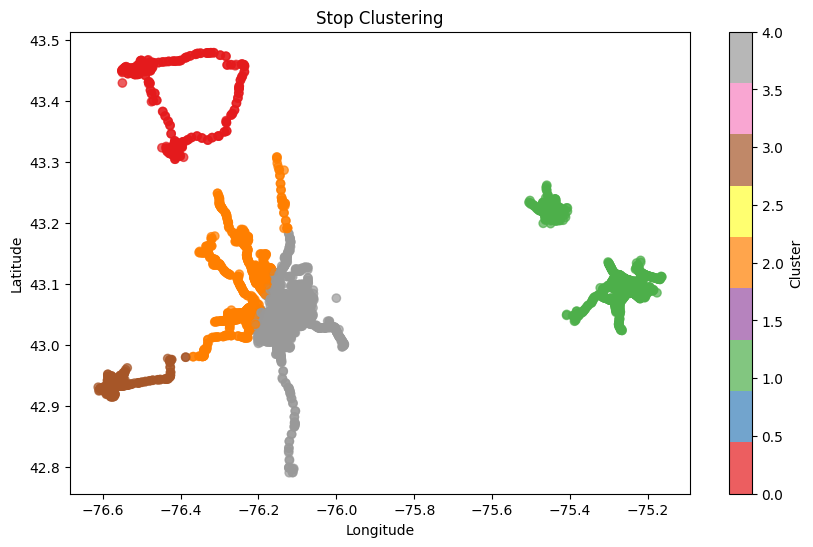

In [ ]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(stops_df['stop_lon'], stops_df['stop_lat'],
                      c=stops_df['cluster'], cmap='Set1', alpha=0.7)

# Adding labels and title
plt.title('Stop Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(scatter, label='Cluster')

# Save the plot as an image (PNG format)
plt.savefig("stops_clusters_plot.png", bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
m = folium.Map(location=[stops_df['stop_lat'].mean(), stops_df['stop_lon'].mean()], zoom_start=14)

color_map = {
    0: 'blue',
    1: 'green',
    2: 'orange',
    3: 'red',
    4: 'purple',
    5: 'darkblue',
    6: 'darkgreen',
    7: 'darkorange',
    8: 'darkred',
    9: 'lightblue'
}

for idx, row in stops_df.iterrows():
    folium.Marker(
        location=[row['stop_lat'], row['stop_lon']],
        popup=row['stop_id'],
        icon=folium.Icon(color=color_map[row['cluster']])
    ).add_to(m)


for cluster in stops_df['cluster'].unique():
    cluster_stops = stops_df[stops_df['cluster'] == cluster]
    folium.Circle(
        location=[cluster_stops['stop_lat'].mean(), cluster_stops['stop_lon'].mean()],
        radius=50,  # Adjust radius as needed
        color=color_map[cluster],
        fill=True,
        fill_opacity=0.5,
        popup=f'Cluster {cluster}'
    ).add_to(m)

m.save("stops_clusters_map.html")

-------
-------
-------

In [ ]:
app = Flask(__name__)

# Define Datas



@app.route('/load_gtfs', methods=['POST'])
def load_gtfs():
    try:
        # Get the file path from the request
        file_path = request.json.get('file_path')
        path = Path(file_path)

        # Read GTFS feed
        feed = gk.read_feed(path, dist_units='km')

        # Process stop_times
        stop_times = feed.stop_times.copy()
        stop_times['arrival_time'] = stop_times['arrival_time'].str.replace(' ', '')
        stop_times['departure_time'] = stop_times['departure_time'].str.replace(' ', '')
        feed.stop_times = stop_times

        # Remove routes with no trips
        routes_with_no_trips = feed.trips['route_id'].unique()
        feed.routes = feed.routes[~feed.routes['route_id'].isin(routes_with_no_trips)]

        # Store processed data in session or return as needed
        routes = feed.routes.copy()
        shapes = feed.shapes.copy()
        stop_times = feed.stop_times.copy()
        stops = feed.stops.copy()
        trips = feed.trips.copy()

        return jsonify({
            'message': 'GTFS data loaded successfully',
            'routes_count': len(routes),
            'shapes_count': len(shapes),
            'stop_times_count': len(stop_times),
            'stops_count': len(stops),
            'trips_count': len(trips)
        }), 200

    except Exception as e:
        return jsonify({'error': str(e)}), 500


In [ ]:
from flask import Flask, request, jsonify
import pandas as pd
import gtfs_kit as gk
from pathlib import Path
import io
import base64

app = Flask(__name__)


@app.route('/clean_data', methods=['GET'])
def clean_data():
    try:
        # Load the GTFS data
        path = Path('/content/gtfs-nyc-2023.zip')
        feed = gk.read_feed(path, dist_units='km')

        # Clean the stop_times data
        stop_times = feed.stop_times.copy()
        stop_times['arrival_time'] = stop_times['arrival_time'].str.replace(' ', '')
        stop_times['departure_time'] = stop_times['departure_time'].str.replace(' ', '')
        feed.stop_times = stop_times

        # Remove routes with no trips
        routes_with_no_trips = feed.trips['route_id'].unique()
        feed.routes = feed.routes[~feed.routes['route_id'].isin(routes_with_no_trips)]

        routes = feed.routes.copy()
        shapes = feed.shapes.copy()
        stop_times = feed.stop_times.copy()
        stops = feed.stops.copy()
        trips = feed.trips.copy()

        # Clean the arrival and departure times
        def clean_time(x):
            date = datetime.datetime.today()
            hr, min, sec = x.split(':')
            if x.startswith('24'):
                date = date + datetime.timedelta(days=1)
                hr = '00'
            x = f"{date.strftime('%Y-%m-%d')} {hr}:{min}:{sec}"
            return x

        stop_times['arrival_time'] = stop_times['arrival_time'].apply(clean_time)
        stop_times['departure_time'] = stop_times['departure_time'].apply(clean_time)

        # Convert to datetime
        stop_times['arrival_time'] = pd.to_datetime(stop_times['arrival_time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
        stop_times['departure_time'] = pd.to_datetime(stop_times['departure_time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

        # Fill missing shape distances
        stop_times['shape_dist_traveled'] = stop_times['shape_dist_traveled'].fillna(0)

        # Clean routes and stops data
        routes = feed.routes[['route_id', 'route_long_name', 'route_type', 'route_color', 'route_text_color']]
        stops = feed.stops[['stop_id', 'stop_code', 'stop_name', 'stop_lat', 'stop_lon']]

        # Merge trips with routes
        trips = feed.trips.copy()
        trips_routes = trips.merge(routes, on='route_id', how='inner')

        # Merge stop times with trips
        stop_times_trips = stop_times.merge(trips_routes, on='trip_id', how='inner')

        # Group shapes and compute total distance
        shapes = feed.shapes.copy()
        shapes_grouped_lat_long = shapes.groupby('shape_id').apply(lambda x: list(zip(x['shape_pt_lat'], x['shape_pt_lon']))).reset_index().rename(columns={0: 'shape_points'})
        grouped_shapes = shapes_grouped_lat_long.merge(shapes.groupby('shape_id').agg(dist_traveled=('shape_dist_traveled', list)), on='shape_id', how='inner')
        grouped_shapes['total_dist_traveled'] = grouped_shapes['dist_traveled'].apply(lambda x: x[-1])

        # Merge trips with shapes
        trips_shapes = trips.merge(grouped_shapes, on='shape_id', how='inner')
        trips_shapes_routes = trips_shapes.merge(routes, on='route_id', how='inner')
        stop_times_trips_shapes = stop_times.merge(trips_shapes_routes, on='trip_id', how='inner')
        stop_times_trips_shapes_stops = stop_times_trips_shapes.merge(stops, on='stop_id', how='inner')

        app.config['STOP_TIMES'] = stop_times
        app.config['ROUTES'] = routes
        app.config['STOPS'] = stops
        app.config['TRIPS'] = trips
        app.config['TRIPS_ROUTES'] = trips_routes
        app.config['STOP_TIMES_TRIPS'] = stop_times_trips
        app.config['STOP_TIMES_TRIPS_SHAPES_STOPS'] = stop_times_trips_shapes_stops
        app.config['GROUPED_SHAPES'] = grouped_shapes
        app.config['TRIPS_SHAPES'] = trips_shapes
        app.config['TRIPS_SHAPES_ROUTES'] = trips_shapes_routes

        # Return success message
        return jsonify({'message': 'GTFS data cleaned successfully!'}), 200

    except Exception as e:
        return jsonify({'error': str(e)}), 500


@app.route('/pareto_chart', methods=['GET'])
def pareto_chart():
    try:
        # Assuming routes_with_trips is already computed in your data loading process
        routes_with_trips = app.config['TRIPS'].groupby(by=['route_id']).agg(TotalTrips=('trip_id', 'count')).sort_values(by='TotalTrips', ascending=False).reset_index()
        routes_with_trips['cum_perc'] = (routes_with_trips['TotalTrips'].cumsum() / routes_with_trips['TotalTrips'].sum() * 100).round(2)


        # Create the Pareto chart
        fig = go.Figure()

        fig.add_trace(go.Bar(
            x=routes_with_trips['route_id'],
            y=routes_with_trips['TotalTrips'],
            name='Total Trips',
            marker_color='blue'
        ))

        fig.add_trace(go.Scatter(
            x=routes_with_trips['route_id'],
            y=routes_with_trips['cum_perc'],
            name='Cumulative Percentage',
            marker_color='red',
            yaxis='y2',
            mode='lines+markers'
        ))

        fig.add_trace(go.Scatter(
            x=routes_with_trips['route_id'],
            y=[80] * routes_with_trips.shape[0],
            yaxis='y2',
            mode='lines',
            line=dict(color='black', dash='dash'),
            name='80% Mark'
        ))

        fig.update_layout(
            title='Pareto Chart of Total Trips by Route',
            xaxis_title='Route ID',
            yaxis_title='Total Trips',
            yaxis2=dict(
                title='Cumulative Percentage',
                overlaying='y',
                side='right',
                range=[0, 100]
            ),
            barmode='overlay',
            legend=dict(x=0, y=1),
            showlegend=True
        )

        # Save the figure as an image (optional)
        fig.write_image("pareto_chart.png")  # Save to file
        return jsonify({'message': 'Pareto chart created successfully'}), 200

    except Exception as e:
        return jsonify({'error': str(e)}), 500


@app.route('/total_stops_vs_total_trips', methods=['GET'])
def total_stops_vs_total_trips():
    try:
        # Assuming routes_metrics is already computed in your data loading process
        routes_metrics = app.config['STOP_TIMES_TRIPS_SHAPES_STOPS'].groupby(by=['route_id']).agg(
            TotalStops=('stop_id', 'nunique'),
            TotalTrips=('trip_id', 'nunique'),
            TotalShapes=('shape_id', 'nunique')
        ).sort_values(by='TotalStops', ascending=False).reset_index()

        # Create scatter plot
        fig = px.scatter(routes_metrics,
                         x='TotalStops',
                         y='TotalTrips',
                         text='route_id',
                         title='Total Stops vs. Total Trips for Each Route',
                         labels={'TotalStops': 'Total Stops', 'TotalTrips': 'Total Trips'},
                         trendline='ols',  # Optional: Add a trendline
                         template='plotly_dark')

        fig.update_traces(textposition='top center')

        # Save the figure as an image (optional)
        fig.write_image("total_stops_vs_total_trips.png")  # Save to file
        return jsonify({'message': 'Total Stops vs. Total Trips scatter plot created successfully'}), 200

    except Exception as e:
        return jsonify({'error': str(e)}), 500


@app.route('/frequent_stops', methods=['GET'])
def frequent_stops():
    try:
        # Retrieve the merged stop_times_trips_shapes_stops DataFrame
        stop_times_trips_shapes_stops = app.config.get('STOP_TIMES_TRIPS_SHAPES_STOPS')
        if stop_times_trips_shapes_stops is None:
            return jsonify({'error': 'GTFS data has not been cleaned yet. Please call the /clean_data endpoint first.'}), 400

        # Calculate frequent stops
        frequent_stops = stop_times_trips_shapes_stops.groupby(by=['stop_id']).agg(
            TotalTrips=('trip_id', 'nunique'),
        ).sort_values(by='TotalTrips', ascending=False).reset_index()

        # Calculate cumulative percentage
        frequent_stops['cum_perc'] = (frequent_stops['TotalTrips'].cumsum() / frequent_stops['TotalTrips'].sum() * 100).round(2)

        # Filter for most frequent stops contributing to 80% of trips
        most_frequent_stops = frequent_stops[frequent_stops['cum_perc'] < 81]

        # Count and percentage of stops contributing to 80% of trips
        number_of_stops = most_frequent_stops.shape[0]
        percent_of_stops = (number_of_stops / frequent_stops.shape[0] * 100).round(2)

        result = {
            'number_of_stops': number_of_stops,
            'percent_of_stops': percent_of_stops,
            'most_frequent_stops': most_frequent_stops.to_dict(orient='records')  # Convert to list of dictionaries
        }

        return jsonify(result), 200
    except Exception as e:
        return jsonify({'error': str(e)}), 500


@app.route('/route_metrics', methods=['GET'])
def route_metrics():
    try:
        # Retrieve the merged stop_times_trips_shapes_stops DataFrame
        stop_times_trips_shapes_stops = app.config.get('STOP_TIMES_TRIPS_SHAPES_STOPS')
        if stop_times_trips_shapes_stops is None:
            return jsonify({'error': 'GTFS data has not been cleaned yet. Please call the /clean_data endpoint first.'}), 400

        # Calculate route metrics
        routes_metrics = stop_times_trips_shapes_stops.groupby(by=['route_id']).agg(
            TotalStops=('stop_id', 'nunique'),
            TotalTrips=('trip_id', 'nunique'),
            TotalShapes=('shape_id', 'nunique')
        ).sort_values(by='TotalStops', ascending=False).reset_index()

        # Prepare stop_times for further calculations
        stop_times = app.config['STOP_TIMES'].sort_values(by=['trip_id', 'stop_sequence'])
        stop_times['time_diff'] = stop_times.groupby(by="trip_id")['arrival_time'].diff().dt.total_seconds() / 60
        stop_times['time_diff'] = stop_times['time_diff'].fillna(0)

        merged_data = pd.merge(stop_times, app.config['TRIPS'][['trip_id', 'shape_id']], on='trip_id')

        merged_data = pd.merge(merged_data, app.config['ROUTES'][['shape_id', 'shape_pt_sequence', 'shape_dist_traveled']],
                               left_on=['shape_id', 'stop_sequence'],
                               right_on=['shape_id', 'shape_pt_sequence'])

        merged_data = merged_data.sort_values(by=['trip_id', 'stop_sequence'])

        merged_data['distance_covered'] = merged_data.groupby('trip_id')['shape_dist_traveled'].diff().fillna(0)

        # Average travel time and Total distance for each trip
        trips_metrics = merged_data.groupby(by=['trip_id']).agg(
            AvgTravelTime=('time_diff', 'mean'),
            TotalDistance=('distance_covered', 'sum')
        ).reset_index()

        # Merging with routes
        trips_metrics = trips_metrics.merge(app.config['TRIPS'][['trip_id', 'route_id']], on='trip_id', how='inner')

        routes_metrics1 = trips_metrics.groupby(by=['route_id']).agg(
            AvgTravelTime=('AvgTravelTime', 'mean'),
            TotalDistance=('TotalDistance', 'sum')
        ).reset_index()

        routes_metrics = routes_metrics.merge(routes_metrics1, on="route_id", how="inner")

        # Create scatter plot
        fig = px.scatter(routes_metrics,
                         x='TotalDistance',
                         y='AvgTravelTime',
                         text='route_id',
                         title='Average Travel Time vs. Total Distance for Each Route',
                         labels={'TotalDistance': 'Total Distance (km)', 'AvgTravelTime': 'Average Travel Time (minutes)'},
                         trendline='ols',  # Optional: Add a trendline
                         template='plotly_dark')

        # Display route ID on hover
        fig.update_traces(textposition='top center')

        # Save plot to a BytesIO object
        img_bytes = io.BytesIO()
        fig.write_image(img_bytes, format='png')
        img_bytes.seek(0)

        # Encode to base64 for JSON response
        plot_url = base64.b64encode(img_bytes.getvalue()).decode('utf8')

        return jsonify({
            'routes_metrics': routes_metrics.to_dict(orient='records'),  # Return metrics as a list of dictionaries
            'plot_url': f"data:image/png;base64,{plot_url}"
        }), 200

    except Exception as e:
        return jsonify({'error': str(e)}), 500


@app.route('/plot_route', methods=['GET'])
def plot_route_on_map_api():
    route_id = request.args.get('route_id')

    if not route_id:
        return jsonify({"status": "error", "message": "route_id parameter is required."}), 400

    trips = app.config['TRIPS']
    stops = app.config['STOPS']
    stop_times = app.config['STOP_TIMES']
    shapes = app.config['SHAPES']

    trips_filtered = trips[trips['route_id'] == route_id]
    trip_ids = trips_filtered['trip_id'].unique()
    stop_times_filtered = stop_times[stop_times['trip_id'].isin(trip_ids)]
    stop_data = pd.merge(stop_times_filtered, stops, on='stop_id')

    stop_data = stop_data.sort_values(by=['trip_id', 'stop_sequence'])
    first_stop = stop_data.groupby('trip_id').first().reset_index()
    last_stop = stop_data.groupby('trip_id').last().reset_index()
    shape_id = trips_filtered.iloc[0]['shape_id']
    shape_data = shapes[shapes['shape_id'] == shape_id].sort_values(by='shape_pt_sequence')

    map_center = [first_stop.iloc[0]['stop_lat'], first_stop.iloc[0]['stop_lon']]
    route_map = folium.Map(location=map_center, zoom_start=12)

    marker_cluster = MarkerCluster().add_to(route_map)

    for _, row in stop_data.iterrows():
        Marker(
            location=[row['stop_lat'], row['stop_lon']],
            popup=f"Stop: {row['stop_name']} (Sequence: {row['stop_sequence']})",
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(marker_cluster)

    Marker(
        location=[first_stop.iloc[0]['stop_lat'], first_stop.iloc[0]['stop_lon']],
        popup=f"Source: {first_stop.iloc[0]['stop_name']}",
        icon=folium.Icon(color='green', icon='play')
    ).add_to(route_map)

    Marker(
        location=[last_stop.iloc[0]['stop_lat'], last_stop.iloc[0]['stop_lon']],
        popup=f"Destination: {last_stop.iloc[0]['stop_name']}",
        icon=folium.Icon(color='red', icon='stop')
    ).add_to(route_map)

    shape_coords = shape_data[['shape_pt_lat', 'shape_pt_lon']].values.tolist()
    folium.PolyLine(locations=shape_coords, color='purple', weight=5, opacity=0.7).add_to(route_map)

    route_map.save(f"{route_id}_route_map.html")  # Save the map as an HTML file
    return jsonify({"status": "success", "message": "Map created.", "map_file": f"{route_id}_route_map.html"})


@app.route('/train_model', methods=['POST'])
def train_model():

    stop_times_trips_shapes_stops = app.config['STOP_TIMES_TRIPS_SHAPES_STOPS']

    # Calculate travel time and distance traveled
    stop_times_trips_shapes_stops['travel_time'] = stop_times_trips_shapes_stops.groupby(by="trip_id")['arrival_time'].diff().dt.total_seconds().fillna(0)
    stop_times_trips_shapes_stops['distance_traveled'] = stop_times_trips_shapes_stops.groupby('trip_id')['shape_dist_traveled'].diff().fillna(0)

    # Convert IDs to integers
    stop_times_trips_shapes_stops['route_id_int'] = stop_times_trips_shapes_stops['route_id'].astype(int)
    stop_times_trips_shapes_stops['trip_id_int'] = stop_times_trips_shapes_stops['trip_id'].astype(int)
    stop_times_trips_shapes_stops['stop_id_int'] = stop_times_trips_shapes_stops['stop_id'].astype(int)

    # Select features and target variable for the model
    X = stop_times_trips_shapes_stops[['stop_sequence', 'distance_traveled', 'route_id_int', 'trip_id_int']]
    y = stop_times_trips_shapes_stops['travel_time']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Create a scatter plot for actual vs predicted travel time
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.xlabel('Actual Travel Time (seconds)')
    plt.ylabel('Predicted Travel Time (seconds)')
    plt.title('Actual vs Predicted Travel Time')

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.write_image('actual_pred.png')
    buf.seek(0)
    img_str = base64.b64encode(buf.read()).decode('utf-8')
    plt.close()

    return jsonify({"status": "success", "message": "Model trained successfully.", "plot": f"data:image/png;base64,{img_str}"})


@app.route('/cluster_stops', methods=['POST'])
def cluster_stops():
    stops_df = app.config['STOPS']

    if 'stop_lat' not in stops_df.columns or 'stop_lon' not in stops_df.columns:
        return jsonify({"status": "error", "message": "Missing latitude or longitude columns."}), 400

    # Prepare the data for clustering
    stop_coords = stops_df[['stop_lat', 'stop_lon']].values

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=10, random_state=42)
    stops_df['cluster'] = kmeans.fit_predict(stop_coords)

    # Create a scatter plot of the clusters
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(stops_df['stop_lon'], stops_df['stop_lat'], c=stops_df['cluster'], cmap='Set1', alpha=0.7)

    # Adding labels and title
    plt.title('Stop Clustering')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar(scatter, label='Cluster')

    # Save the plot to a bytes buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    plt.write_image('cluster.png')
    buf.seek(0)
    img_str = base64.b64encode(buf.read()).decode('utf-8')
    plt.close()

    # Return the plot as a base64 encoded string
    return jsonify({"status": "success", "message": "Clustering completed successfully.", "plot": f"data:image/png;base64,{img_str}"})


if __name__ == '__main__':
    app.run(debug=True)